## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import glob
import time
import requests
import argparse
import subprocess
import numpy as np
import pandas as pd
import numexpr as ne
import dask.array as da
import astropy.units as au
import dask.dataframe as dd
import astropy.constants as ac
import matplotlib.pyplot as plt
from io import StringIO
from itertools import chain
from tqdm.notebook import tqdm
from pandarallel import pandarallel
from indexed_bzip2 import IndexedBzip2File
from matplotlib.collections import LineCollection
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Process, Pool, freeze_support
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.special import voigt_profile, wofz, erf, roots_hermite

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
pd.options.mode.chained_assignment = None

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import multiprocessing as mp
freeze_support()
num_cpus = mp.cpu_count()
print('Number of CPU: ', num_cpus)

# import vaex

Number of CPU:  256


In [2]:
%load_ext version_information
%version_information pandas, numpy

Software versions
Python 3.9.18 64bit [GCC 11.4.1 20231218 (Red Hat 11.4.1-3)]
IPython 8.12.3
OS Linux 5.14.0 362.8.1.el9_3.x86_64 x86_64 with glibc2.34
pandas 2.0.3
numpy 1.22.3
Mon May 27 15:12:28 2024 BST

In [3]:
%load_ext watermark
%watermark
%watermark --watermark
%watermark --iversions

Last updated: 2024-05-27T15:12:28.642823+01:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.3

Compiler    : GCC 11.4.1 20231218 (Red Hat 11.4.1-3)
OS          : Linux
Release     : 5.14.0-362.8.1.el9_3.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 256
Architecture: 64bit

Watermark: 2.4.3

numexpr   : 2.8.8
matplotlib: 3.8.2
requests  : 2.31.0
pandas    : 2.0.3
astropy   : 6.0.0
argparse  : 1.1
numpy     : 1.22.3
dask      : 2024.1.0



## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [4]:
#########################################################
inp_filepath = '/home/jingxin/PyExoCross/input/MgH_exomol_recommended.inp'
#########################################################

## Report time

In [5]:
class Timer:    
    def start(self):
        self.start_CPU = time.process_time()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')
        
    def cal(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        return(self.interval_CPU, self.interval_sys)

## Read Information from Input File

In [6]:
class InputWarning(UserWarning):
    pass

In [7]:
def inp_para(inp_filepath):
    # Find the maximum column for all the rows.
    with open(inp_filepath, 'r') as temp_f:
        col_count = max([len([x for x in l.split(" ") if x.strip()]) for l in temp_f.readlines()])
    # Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1).
    column_names = [i for i in range(col_count)] 
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', header = None, names=column_names, usecols=column_names)
    col0 = inp_df[0]
    
    # Database
    database = inp_df[col0.isin(['Database'])][1].values[0].upper().replace('EXOMOL','ExoMol')
    
    # Basic information
    molecule = inp_df[col0.isin(['Molecule'])][1].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])][1].values[0]
    dataset = inp_df[col0.isin(['Dataset'])][1].values[0]
    mol_iso_id = int(inp_df[col0.isin(['MolIsoID'])][1].iloc[0])
    
    # File path
    read_path = inp_df[col0.isin(['ReadPath'])][1].values[0]
    save_path = inp_df[col0.isin(['SavePath'])][1].values[0]
    if os.path.exists(save_path):
        pass
    else:
        os.makedirs(save_path, exist_ok=True)
        
    # Functions 
    Conversion = int(inp_df[col0.isin(['Conversion'])][1].iloc[0])
    PartitionFunctions = int(inp_df[col0.isin(['PartitionFunctions'])][1].iloc[0])
    CoolingFunctions = int(inp_df[col0.isin(['CoolingFunctions'])][1].iloc[0])
    Lifetimes = int(inp_df[col0.isin(['Lifetimes'])][1].iloc[0])
    OscillatorStrengths = int(inp_df[col0.isin(['OscillatorStrengths'])][1].iloc[0])
    SpecificHeats = int(inp_df[col0.isin(['SpecificHeats'])][1].iloc[0])
    StickSpectra = int(inp_df[col0.isin(['StickSpectra'])][1].iloc[0])
    NonLTE = int(inp_df[col0.isin(['Non-LTE'])][1].iloc[0])
    CrossSections = int(inp_df[col0.isin(['CrossSections'])][1].iloc[0])
    
    # Cores and chunks
    ncputrans = int(inp_df[col0.isin(['NCPUtrans'])][1].iloc[0])
    ncpufiles = int(inp_df[col0.isin(['NCPUfiles'])][1].iloc[0])
    chunk_size = int(inp_df[col0.isin(['ChunkSize'])][1].iloc[0])
    
    # Quantum numbers
    NeedQNs = Conversion + StickSpectra + CrossSections
    if NeedQNs != 0:
        QNslabel_list = list(inp_df[col0.isin(['QNslabel'])].iloc[0])[1:]
        QNsformat_list = list(inp_df[col0.isin(['QNsformat'])].iloc[0])[1:]
        QNslabel_list = [x for x in QNslabel_list if x == x]
        QNsformat_list = [x for x in QNsformat_list if x == x]
    else:
        QNslabel_list = []
        QNsformat_list = []  
    
    # Convert from one format to another
    if Conversion != 0:
        ConversionFormat = int(inp_df[col0.isin(['ConversionFormat'])][1].iloc[0])
        ConversionMinFreq = float(inp_df[col0.isin(['ConversionFrequncyRange'])][1].iloc[0])
        ConversionMaxFreq = float(inp_df[col0.isin(['ConversionFrequncyRange'])][2].iloc[0])
        GlobalQNLabel_list = list(inp_df[col0.isin(['GlobalQNLabel'])].iloc[0].dropna())[1:]
        GlobalQNFormat_list = list(inp_df[col0.isin(['GlobalQNFormat'])].iloc[0].dropna())[1:]
        LocalQNLabel_list = list(inp_df[col0.isin(['LocalQNLabel'])].iloc[0].dropna())[1:]
        LocalQNFormat_list = list(inp_df[col0.isin(['LocalQNFormat'])].iloc[0].dropna())[1:]
        # Uncertainty filter
        ConversionUncYN = inp_df[col0.isin(['ConvUncFilter(Y/N)'])][1].values[0].upper()[0]
        if ConversionUncYN == 'Y':
            ConversionUnc = float(inp_df[col0.isin(['ConvUncFilter(Y/N)'])][2].iloc[0])
        elif ConversionUncYN == 'N':
            ConversionUnc = 'None'
        else:
            raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")  
        # Threshold filter
        ConversionThresholdYN = inp_df[col0.isin(['ConvThreshold(Y/N)'])][1].values[0].upper()[0]
        if ConversionThresholdYN == 'Y':
            ConversionThreshold = float(inp_df[col0.isin(['ConvThreshold(Y/N)'])][2].iloc[0])
        elif ConversionThresholdYN == 'N':
            ConversionThreshold = 'None'
        else:
            raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.")       
    else:
        ConversionFormat = 0
        ConversionMinFreq = 0
        ConversionMaxFreq = 1e20
        GlobalQNLabel_list = []
        GlobalQNFormat_list = []
        LocalQNLabel_list = []
        LocalQNFormat_list = []
        ConversionUnc = 'None'
        ConversionThreshold = 'None'
        
    # Calculate partition, cooling functions or specific heats 
    if PartitionFunctions + CoolingFunctions + SpecificHeats != 0:
        Ntemp = int(inp_df[col0.isin(['Ntemp'])][1].iloc[0])    # The number of temperature steps
        Tmax = int(inp_df[col0.isin(['Tmax'])][1].iloc[0])      # Maximal temperature in K (minimal T = 1 K )
    else:
        Ntemp = 0
        Tmax = 0  
     
    # Calculate lifetimes 
    if Lifetimes != 0:
        CompressYN = inp_df[col0.isin(['Compress(Y/N)'])][1].values[0].upper()[0]
    else:
        CompressYN = 'N'
        
    # Calculate oscillator strengths
    if OscillatorStrengths != 0:
        gfORf = inp_df[col0.isin(['gf/f'])][1].values[0].upper()
        PlotOscillatorStrengthYN = inp_df[col0.isin(['PlotOscillatorStrength(Y/N)'])][1].values[0].upper() 
        if PlotOscillatorStrengthYN == 'Y':
            _limitYaxisOS = inp_df[col0.isin(['Y-axisLimitOscillatorStrength'])][1].values[0]
            if _limitYaxisOS == '#':
                limitYaxisOS = 1e-30
            elif pd.isnull(_limitYaxisOS) == True:
                limitYaxisOS = 1e-30
            else:
                limitYaxisOS = float(_limitYaxisOS)
        else:
            limitYaxisOS = 0
    else:
        gfORf = 'GF'
        PlotOscillatorStrengthYN = 'None'
        limitYaxisOS = 0
    
    # Calculate stick spectra or cross sections 
    if StickSpectra + CrossSections != 0:
        T = int(inp_df[col0.isin(['Temperature'])][1].iloc[0])
        min_wn = float(inp_df[col0.isin(['Range'])][1].iloc[0])
        max_wn = float(inp_df[col0.isin(['Range'])][2].iloc[0])
        abs_emi = inp_df[col0.isin(['Absorption/Emission'])][1].values[0].upper()[0].replace('A','Ab').replace('E','Em')
        # Uncertainty filter
        UncFilterYN = inp_df[col0.isin(['UncFilter(Y/N)'])][1].values[0].upper()[0]
        if UncFilterYN == 'Y':
            UncFilter = float(inp_df[col0.isin(['UncFilter(Y/N)'])][2].iloc[0])
        elif UncFilterYN == 'N':
            UncFilter = 'None'
        else:
            raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")  
        # Threshold filter
        thresholdYN = inp_df[col0.isin(['Threshold(Y/N)'])][1].values[0].upper()[0]
        if thresholdYN == 'Y':
            threshold = float(inp_df[col0.isin(['Threshold(Y/N)'])][2].iloc[0])
        elif thresholdYN == 'N':
            threshold = 'None'
        else:
            raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.") 
        # Quantum number filter
        QNsFilterYN = inp_df[col0.isin(['QNsFilter(Y/N)'])][1].values[0].upper()[0]
        if QNsFilterYN == 'Y':
            QNsFilter = list(inp_df[col0.isin(['QNsFilter(Y/N)'])].iloc[0].dropna())[2:]
            QNs_label = []
            QNs_value = []
            for i in range(len(QNsFilter)):
                QNs_label.append(QNsFilter[i].split('[')[0])
                QNs_value.append(QNsFilter[i].split('[')[1].split(']')[0].split(';'))
            QNs_format = [QNsformat_list[j] for j in [QNslabel_list.index(i) for i in QNs_label]]
        elif QNsFilterYN == 'N':
            QNsFilter = []
            QNs_label = []
            QNs_value = []
            QNs_format = []
        else:
            raise ImportError("Please type the correct quantum number filter choice 'Y' or 'N' into the input file.")
    else:
        T = 0
        min_wn = 0
        max_wn = 1e20
        abs_emi = 'None'
        UncFilter = 'None'
        threshold = 'None'
        QNsFilter = []
        QNs_label = []
        QNs_value = []  
        QNs_format = []
        
    # Stick spectra
    if StickSpectra != 0:
        PlotStickSpectraYN = inp_df[col0.isin(['PlotStickSpectra(Y/N)'])][1].values[0].upper()[0]
        if PlotStickSpectraYN == 'Y':
            _limitYaxisStickSpectra = inp_df[col0.isin(['Y-axisLimitStickSpectra'])][1].values[0]
            if _limitYaxisStickSpectra == '#':
                limitYaxisStickSpectra = 1e-30
            elif pd.isnull(_limitYaxisStickSpectra) == True:
                limitYaxisStickSpectra = 1e-30
            else:
                limitYaxisStickSpectra = float(_limitYaxisStickSpectra)
        else:
            limitYaxisStickSpectra = 0
    else:
        PlotStickSpectraYN = 'None'
        limitYaxisStickSpectra = 0

    # Non-LTE
    if NonLTE != 0:
        Tvib = int(inp_df[col0.isin(['Tvib'])][1].iloc[0])
        Trot = int(inp_df[col0.isin(['Trot'])][1].iloc[0])
        vib_label = inp_df[col0.isin(['QNsVibLabel'])][1].iloc[0].replace(' ','').split(',')
        rot_label = inp_df[col0.isin(['QNsRotLabel'])][1].iloc[0].replace(' ','').split(',')
        PlotNLTEYN = inp_df[col0.isin(['PlotNonLTE(Y/N)'])][1].values[0].upper()[0]
        if PlotNLTEYN == 'Y':
            _limitYaxisNLTE = inp_df[col0.isin(['Y-axisLimitNonLTE'])][1].values[0]
            if _limitYaxisNLTE == '#':
                limitYaxisNLTE = 1e-30
            elif pd.isnull(_limitYaxisNLTE) == True:
                limitYaxisNLTE = 1e-30
            else:
                limitYaxisNLTE = float(_limitYaxisNLTE)
        else:
            limitYaxisNLTE = 0
    else:
        Tvib = 0
        Trot = 0
        vib_label = []
        rot_label = []
        PlotNLTEYN = 'None'
        limitYaxisNLTE = 0
        
    # Cross sections
    if CrossSections != 0:
        NpointsORBinSize = inp_df[col0.isin(['Npoints/BinSize'])][1].values[0].upper()
        if 'POI' in NpointsORBinSize:
            N_point = int(inp_df[col0.isin(['Npoints/BinSize'])][2].iloc[0])
            bin_size = float((max_wn - min_wn)/(N_point-1))
        elif 'BIN' in NpointsORBinSize or 'SIZ' in NpointsORBinSize:
            bin_size = float(inp_df[col0.isin(['Npoints/BinSize'])][2].iloc[0])
            N_point = int((max_wn - min_wn)/bin_size+1)
        else:
            raise ImportError("Please type the correct grid choice 'Npoints' or 'BinSize' into the input file.")
        # Predissociative cross sections
        predissocYN = inp_df[col0.isin(['PredissocXsec(Y/N)'])][1].values[0].upper()[0]
        if predissocYN != 'Y' and predissocYN != 'N':
            raise ImportError("Please type the correct predissociative choice 'Y' or 'N' into the input file.")        
        # Cutoff
        cutoffYN = inp_df[col0.isin(['Cutoff(Y/N)'])][1].values[0].upper()[0]
        if cutoffYN == 'Y':
            cutoff = float(inp_df[col0.isin(['Cutoff(Y/N)'])][2].iloc[0])
        elif cutoffYN == 'N':
            cutoff = 'None'
        else:
            raise ImportError("Please type the correct cutoff choice 'Y' or 'N' into the input file.")
        # Other parameters
        P = float(inp_df[col0.isin(['Pressure'])][1].iloc[0])
        broadeners = list(inp_df[col0.isin(['Broadeners'])].iloc[0])[1:]
        broadeners = [i for i in broadeners if i is not np.nan]
        ratios = np.array(list(inp_df[col0.isin(['Ratios'])].iloc[0])[1:], dtype=float)
        ratios = ratios[~np.isnan(ratios)]
        wn_grid = np.linspace(min_wn, max_wn, N_point)
        wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])][1].values[0].upper()
        profile = inp_df[col0.isin(['Profile'])][1].values[0].upper().replace('PRO','')
        # Doppler HWHM
        DopplerHWHMYN = inp_df[col0.isin(['DopplerHWHM(Y/N)'])][1].values[0].upper()[0]        
        if 'DOP' in profile: 
            alpha_HWHM = 'None'
        elif 'GAU' in profile:
            if DopplerHWHMYN == 'Y':
                alpha_HWHM = float(inp_df[col0.isin(['DopplerHWHM(Y/N)'])][2].iloc[0])
            else:
                raise ImportError("Gaussian line profile requires a HWHM. " 
                                  + "Please choose 'Y' and give a value for Doppler HWHM in the input file. " 
                                  + "Otherwise, please choose Doppler line profile " 
                                  + "(with calculated temperature-dependent Doppler HWHM).")
        elif 'VOI' in profile:
            if DopplerHWHMYN == 'Y':
                alpha_HWHM = float(inp_df[col0.isin(['DopplerHWHM(Y/N)'])][2].iloc[0])
            elif DopplerHWHMYN == 'N':
                alpha_HWHM = 'None'
            else:
                raise ImportError("Please type the correct Doppler HWHM choice 'Y' or 'N' into the input file.")
        else:
            alpha_HWHM = 'None'
        # Lorentzian HWHM 
        LorentzianHWHMYN = inp_df[col0.isin(['LorentzianHWHM(Y/N)'])][1].values[0].upper()[0]  
        if LorentzianHWHMYN == 'Y':
            gamma_HWHM = float(inp_df[col0.isin(['LorentzianHWHM(Y/N)'])][2].iloc[0])
        elif LorentzianHWHMYN == 'N':
            gamma_HWHM = 'None'
        else:
            raise ImportError("Please type the correct Lorentzian HWHM choice 'Y' or 'N' into the input file.")
        # Plot 
        PlotCrossSectionYN = inp_df[col0.isin(['PlotCrossSection(Y/N)'])][1].values[0].upper()[0]  
        if PlotCrossSectionYN == 'Y':
            _limitYaxisXsec = inp_df[col0.isin(['Y-axisLimitXsec'])][1].values[0]
            if _limitYaxisXsec == '#':
                limitYaxisXsec = 1e-30
            elif pd.isnull(_limitYaxisXsec) == True:
                limitYaxisXsec = 1e-30
            else:
                limitYaxisXsec = float(_limitYaxisXsec)
        else:
            limitYaxisXsec = 0
    else:
        bin_size = 'None'
        N_point = 'None'
        predissocYN = 'N'
        cutoff = 'None'         
        alpha_HWHM = 'None'        
        gamma_HWHM = 'None'
        broadeners = []
        ratios = np.array([])
        P = 0
        wn_grid = np.linspace(0,1,1)
        profile = 'None'
        wn_wl = 'None'
        PlotCrossSectionYN = 'None'
        limitYaxisXsec = 0

    # Molecule and isotopologue ID, abundance, mass uncertainty, lifetime and g-factor           
    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
    if database == 'ExoMol':
        # Read ExoMol definition file (.def) to get the mass.
        deffile_path = (read_path+'/'+molecule+'/'+isotopologue+'/'+dataset+'/'+isotopologue+'__'+dataset+'.def')
        def_df = pd.read_csv(deffile_path,sep='\\s+',usecols=[0,1,2,3,4],names=['0','1','2','3','4'],header=None)
        abundance = 1
        mass = float(def_df[def_df['4'].isin(['mass'])]['0'].values[0])     # ExoMol mass (Dalton)
        if def_df.to_string().find('Uncertainty') != -1:
            check_uncertainty = int(def_df[def_df['2'].isin(['Uncertainty'])]['0'].values[0])
        else:
            check_uncertainty = 0
        if def_df.to_string().find('Predissociative') != -1:
            check_predissoc = int(def_df[def_df['2'].isin(['Predissociative'])]['0'].values[0])
        else:
            check_predissoc = 0
        check_lifetime = int(def_df[def_df['2'].isin(['Lifetime'])]['0'].values[0])
        check_gfactor = int(def_df[def_df['3'].isin(['g-factor'])]['0'].values[0])
    elif database == 'HITRAN':
        isometa_url = 'https://hitran.org/docs/iso-meta/'
        iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
        iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
        abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
        mass = float(iso_meta_row['Molar Mass /g·mol-1'])                   # HITRAN molar mass (g/mol)
        check_uncertainty = 0
        check_predissoc = 0
        check_lifetime = 0
        check_gfactor = 0
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")

    if predissocYN == 'Y' and check_predissoc == 0 and 'LOR' not in profile:
        warnings.warn('Program will cost much time on calculating predissociative lifetimes before calculating the cross sections.\n',InputWarning)
            
    return (database, molecule, isotopologue, dataset, read_path, save_path, 
            Conversion, PartitionFunctions, SpecificHeats, CoolingFunctions, Lifetimes, OscillatorStrengths, StickSpectra, NonLTE, CrossSections,
            ncputrans, ncpufiles, chunk_size, ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
            GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
            Ntemp, Tmax, CompressYN, gfORf, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
            predissocYN, cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNs_format, QNsFilter, 
            alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass,
            check_uncertainty, check_lifetime, check_gfactor, check_predissoc, PlotOscillatorStrengthYN, limitYaxisOS,
            PlotStickSpectraYN, limitYaxisStickSpectra, Tvib, Trot, vib_label, rot_label, 
            PlotNLTEYN, limitYaxisNLTE, PlotCrossSectionYN, limitYaxisXsec)


## Constants and Parameters

In [8]:
# Parameters for calculating
Tref = 296.0                        # Reference temperature is 296 K
Pref = 1.0                          # Reference pressure is 1 bar
N_A = ac.N_A.value                  # Avogadro number (1/mol)
h = ac.h.to('erg s').value          # Planck's const (erg s)
c = ac.c.to('cm/s').value           # Velocity of light (cm/s)
kB = ac.k_B.to('erg/K').value       # Boltzmann's const (erg/K)
R = ac.R.to('J / (K mol)').value    # Molar gas constant (J/(K mol))
c2 = h * c / kB                     # Second radiation constant (cm K)

(database, molecule, isotopologue, dataset, read_path, save_path, 
 Conversion, PartitionFunctions, SpecificHeats, CoolingFunctions, Lifetimes, OscillatorStrengths, StickSpectra, NonLTE, CrossSections,
 ncputrans, ncpufiles, chunk_size, ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
 GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
 Ntemp, Tmax, CompressYN, gfORf, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
 predissocYN, cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNs_format, QNsFilter, 
 alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass, 
 check_uncertainty, check_lifetime, check_gfactor, check_predissoc, PlotOscillatorStrengthYN, limitYaxisOS,
 PlotStickSpectraYN, limitYaxisStickSpectra, Tvib, Trot, vib_label, rot_label, 
 PlotNLTEYN, limitYaxisNLTE, PlotCrossSectionYN, limitYaxisXsec) = inp_para(inp_filepath)

# Constants
c2InvTref = c2 / Tref                 # c2 / T_ref (cm)
hc = h * c                            # erg cm
PI = np.pi
ln22 = np.log(2)*2
sinPI = np.sin(np.pi)
SqrtPI = np.sqrt(np.pi)
Sqrtln2 = np.sqrt(np.log(2))
OneminSqrtPIln2 = 1 - np.sqrt(np.pi * np.log(2))
Negln2 = -np.log(2)
PI4c = np.pi * 4 * c
Inv8Pic = 1 / (8 * np.pi * c)         # 8 * pi * c (s/cm)
Inv4Pi = 1 / (4 * np.pi)
Inv2ln2 = 1 / (2 * np.log(2))
InvSqrt2 = 1 / np.sqrt(2)
InvSqrtPi= 1 / np.sqrt(np.pi)
InvSprtln2 = 1 / np.sqrt(np.log(2))
InvSqrt2Pi = 1 / np.sqrt(2 * np.pi)
InvSqrt2ln2 = 1 / np.sqrt(2 * np.log(2))
TwoSqrt2ln2 = 2 * np.sqrt(2 * np.log(2))
Sqrtln2InvPi = np.sqrt(np.log(2) / np.pi)
Sqrt2NAkBln2mInvc = np.sqrt(2 * N_A * kB * np.log(2) / mass) / c
if bin_size != 'None':
    binSize2 = bin_size * 2
    binSizePI = bin_size * np.pi
    binSizeHalf = bin_size / 2 
    InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)


## Convert frequency, upper and lower energy and J

In [9]:
# Calculate frequency
def cal_v(Ep, Epp):
    v = ne.evaluate('Ep - Epp')
    return(v)

In [10]:
# Calculate upper state energy with ExoMol database
def cal_Ep(Epp, v):
    Ep = ne.evaluate('Epp + v')
    return(Ep)

In [11]:
# Calculate upper state energy with HITRAN database
def cal_Ep_hitran(hitran_df):
    Epp = hitran_df['Epp'].values
    v = hitran_df['v'].values
    Ep = cal_Ep(Epp, v)
    Ep_df = pd.DataFrame(Ep,columns=['Ep'])
    return(Ep_df)

In [12]:
# Calculate upper J
def cal_Jp(Fp, Fpp, Jpp):
    Jp = ne.evaluate('Fp + Fpp - Jpp')
    return(Jp)

In [13]:
# Calculate F
def cal_F(g):
    F = ne.evaluate('(g - 1) * 0.5')
    return(F)

# Read Input Files

Read the parameters of the linelist in ExoMol or HITRAN format text file. Return the dataframe of the data for the following calculations.

## Read ExoMol Database Files

### Read States File


In [14]:
def read_all_states(read_path):
    t = Timer()
    t.start()
    print('Reading states ...')
    states_df = pd.DataFrame()
    states_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                       + '/' + isotopologue + '__' + dataset + '.states.bz2')
    if os.path.exists(states_filename):    
        chunks = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                             chunksize=100_000, iterator=True, low_memory=False, dtype=object)
    elif os.path.exists(states_filename.replace('.bz2','')):
        chunks = pd.read_csv(states_filename.replace('.bz2',''), sep='\s+', header=None,
                             chunksize=100_000, iterator=True, low_memory=False, dtype=object)
    else:
        raise ImportError("No such states file, please check the read path and states filename format!")

    for chunk in chunks:
        states_df = pd.concat([states_df, chunk])
    if check_uncertainty == 1:
        states_df = states_df.rename(columns={0:'id',1:'E',2:'g',3:'J',4:'unc'})
        convert_dict = {'id':np.int32,'E':np.float64,'g':np.int32,'J':np.float16,'unc':np.float32}
        states_df = states_df.astype(convert_dict)
    else:      
        states_df = states_df.rename(columns={0:'id',1:'E',2:'g',3:'J'})  
        convert_dict = {'id':np.int32,'E':np.float64,'g':np.int32,'J':np.float16}
        states_df = states_df.astype(convert_dict)
    t.end()     
    print('Finished reading states!\n')       
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')                
    return(states_df)

### Decompress Large .trans.bz2 Files


In [15]:
### Decompress Large .trans.bz2 Files
def command_decompress(trans_filename):
    # Directory where the decompressed .trans files will be saved
    trans_dir = read_path+molecule+'/'+isotopologue+'/'+dataset+'/decompressed/'
    if os.path.exists(trans_dir):
        pass
    else:
        # Create the output directory if it doesn't exist
        os.makedirs(trans_dir, exist_ok=True)
    trans_file = os.path.join(trans_dir, trans_filename.split('/')[-1].replace('.bz2', ''))
    if os.path.exists(trans_file):
        num = 0
    else:
        command = f'bunzip2 < {trans_filename} > {trans_file}'
        print('Decompressing file:', trans_filename)
        subprocess.run(command, shell=True)
        num = 1
    return(trans_file, num)

### Get Transitions Files

In [16]:
# from indexed_bzip2 import IndexedBzip2File
# def read_trans(trans_filename):
#     file = IndexedBzip2File(trans_filename, parallelization=num_cpus)
#     lines = file.readlines()
#     file.close()
#     u, l, A = [], [], []
#     for line in lines:
#         part = line.split()
#         u.append(int(part[0]))
#         l.append(int(part[1]))
#         A.append(float(part[2]))   
#     trans_df = pd.DataFrame({'u':u, 'l':l, 'A':A})
#     return trans_df

In [17]:
def get_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*.trans.bz2')
    if trans_filepaths_all == []:
        trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*.trans')
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    all_decompress_num = 0
    decompress_num = 0
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in four formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            elif len(split_version[0].split('-')) == 2:
                file_size_bytes = os.path.getsize(trans_filepaths_all[i])
                if file_size_bytes/1024**3 > 1:   
                    (trans_filepath, num) = command_decompress(trans_filepaths_all[i])
                    all_decompress_num += 1
                    decompress_num += num
                else:
                    trans_filepath = trans_filepaths_all[i]
                trans_filepaths.append(trans_filepath)
            else:
                pass
        else:
            pass
    print('Number of all transitions files \t\t:', num_transfiles_all)
    print('Number of all decompressed transitions files \t:', all_decompress_num)
    print('Number of new decompressed transitions files \t:', decompress_num)
    return trans_filepaths    

### Read Partition Function File From ExoMol Database

In [18]:
# Read partition function with online webpage
def read_exomolweb_pf(T):
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]
    return(Q)

In [19]:
# Read partition function with local partition function file
def read_exomol_pf(read_path, T):
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]
    return(Q)

### Read Broadening File

In [20]:
def read_broad(read_path):
    print('Reading broadening file ...')
    broad_df = pd.DataFrame()
    broad_dfs = []
    broad = []
    ratio = []
    for i in range(len(ratios)):
        if ratios[i] != 0.0:
            if broadeners[i].upper()[0:3] == 'DEF':
                default_gamma_L = 0.07
                default_n_air = 0.5
                broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']])
                broad_df = broad_df.rename(columns={0:'code', 1:'gamma_L', 2:'n_air', 3:'Jpp'})
                broad_dfs.append(broad_df)
            else:
                broadener_name = str(broadeners[i])
                pattern_broadener = read_path + molecule + '/**/*' + broadener_name + '.broad'
                if glob.glob(pattern_broadener, recursive=True) != []:
                    for fname_broadener in glob.glob(pattern_broadener, recursive=True):
                        broad_df = pd.read_csv(fname_broadener, sep='\s+', header=None, engine='python')
                        broad_df = broad_df.rename(columns={0:'code', 1:'gamma_L', 2:'n_air', 3:'Jpp'})
                        broad_dfs.append(broad_df)
                else:
                    raise ImportError('The ' + broadener_name + ' boradening file does not exist.') 
            broad.append(broadeners[i])
            ratio.append(ratios[i])
    nbroad = len(broad)
    broad = list(i for i in broad if i==i)
    ratio = list(i for i in ratio if i==i)
    print('Broadeners \t:', str(broad).replace('[','').replace(']','').replace("'",''))
    print('Ratios \t\t:', str(ratio).replace('[','').replace(']',''),'\n')
    return(broad, ratio, nbroad, broad_dfs)        


# Quantum number filter

In [21]:
def QNfilter_linelist(linelist_df, QNs_value, QNs_label):
    for i in range(len(QNs_label)):
        if QNs_value[i] != ['']:
            linelist_df[i] = linelist_df[[QNs_label[i]+"'",QNs_label[i]+'"']].fillna('').agg(','.join, axis=1).astype(str).str.replace(' ', '')
            uval = linelist_df[QNs_label[i]+"'"].astype(str).str.replace(' ', '').drop_duplicates().values
            lval = linelist_df[QNs_label[i]+'"'].astype(str).str.replace(' ', '').drop_duplicates().values
            vallist = []
            ulist = []
            llist = []
            for qnval in QNs_value[i]:
                if '' not in qnval.split(','):
                    vallist.append(qnval)
                elif qnval.split(',')[0] == '':
                    ulist.append([qnval.replace(",",val+",") for val in uval])
                elif qnval.split(',')[1] == '':
                    llist.append([qnval.replace(",",","+val) for val in lval])
            QNs_value[i] = vallist+list(chain(*ulist))+list(chain(*llist))
            linelist_df = linelist_df[linelist_df[i].isin(QNs_value[i])].drop(columns=[i])   
    # linelist_df = linelist_df.sort_values('v')  
    return(linelist_df)   

## Read HITRAN Database Files

### Read HITRAN Linelist File

In [22]:
def read_parfile(read_path):
    if not os.path.exists(read_path):
        raise ImportError('The input file ' + read_path + ' does not exist.')
    # Initialise the iterator object.
    read_par = pd.read_csv(read_path, chunksize=100_000, iterator=True, header=None, encoding='utf-8')
    par_df = pd.DataFrame()
    for chunk in read_par:
        par_df = pd.concat([par_df, chunk])
    return(par_df)

In [23]:
# Process HITRAN linelist data
def read_hitran_parfile(read_path, parfile_df, minv, maxv, unclimit, Slimit):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2020 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = read_path.split('/')[-1]
    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2020 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()
    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int64')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int64')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2}))
    hitran_df['A'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')             # The Einstein-A coefficient (s^{-1}) of a transition
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    #hitran_df['Unc'] = parfile_df[0].map(lambda x: x[127:128])                                                          # Uncertainty code, first integer in the error code
    hitran_df['Unc'] = pd.to_numeric(parfile_df[0].map(lambda x: x[127:128]), errors='coerce').astype('int64')           # Uncertainty code, first integer in the error code
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('int64')            # Statistical weight of the upper state
    hitran_df['gpp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[153:160]), errors='coerce').astype('int64')           # Statistical weight of the lower state
    
    hitran_df = hitran_df[hitran_df['M'].isin([molecule_id])]
    hitran_df = hitran_df[hitran_df['I'].isin([isotopologue_id])]
    hitran_df = hitran_df[hitran_df['v'].between(minv, maxv)]
    if unclimit != 'None':
        hitran_df = hitran_df[hitran_df['Unc'] >= int(('%e' % unclimit)[-1])]
    if Slimit != 'None':
        hitran_df = hitran_df[hitran_df['S'] >= Slimit]
    return(hitran_df)

### Read Partition Function File From HITRANOnline

In [24]:
# Read partition function file from HITRANOnline
def read_hitran_pf(T):
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    #Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]          
    return(Q)

## Process HITRAN quantum numbers

In [25]:
# Global quantum numbers
def globalQNclasses(molecule,isotopologue):
    globalQNclass1a = {'class':['CO','HF','HBr','HI','N2','NO+','NO_p','H2','CS'],
                       'label': ['none','v1'],
                       'format':['%13s','%2d']}
    globalQNclass1b = {'class':['O2','NO','OH','ClO','SO'],
                       'label':['none','X','Omega','none','v1'],
                       'format':['%6s','%2s','%3s','%2s','%2d']}
    globalQNclass2a = {'class':['CO2'],
                       'label':['none','v1','v2','l2','v3','r'],
                       'format':['%6s','%2d','%2d','%2d','%2d','%1d']}
    globalQNclass2b = {'class':['N2O','OCS','HCN','CS2'],
                       'label':['none','v1','v2','l2','v3'],
                       'format':['%7s','%2d','%2d','%2d','%2d']}
    globalQNclass3  = {'class':['H2O','O3','SO2','NO2','HOCl','H2S','HO2','HOBr'],
                       'label':['none','v1','v2','v3'],
                       'format':['%9s','%2d','%2d','%2d']}
    globalQNclass4a = {'class':['15N-1H3','PH3','NF3'],
                       'label':['none','v1','v2','v3','v4','S'],
                       'format':['%5s','%2d','%2d','%2d','%2d','%2s']}
    globalQNclass4b = {'class':['14N-1H3'],
                       'label':['none','v1','v2','v3','v4','none','l3','l4','none','l','none','Gvib'],
                       'format':['%1s','%1d','%1d','%1d','%1d','%1s','%1d','%1d','%1s','%1d','%1s','%4s']}
    globalQNclass5a = {'class':['C2H2'],
                       'label':['none','v1','v2','v3','v4','v5','l4','l5','+-','none','S'],
                       'format':['%1s','%1d','%1d','%1d','%2d','%2d','%2d','%2d','%1s','%1s','%1s']}
    globalQNclass5b = {'class':['C4H2'],
                       'label':['none','v1','v2','v3','v4','v5','v6','v7','v8','v9','none','Sym','none','S'],
                       'format':['%1s','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1s','%1s','%1s','%2s']}
    globalQNclass5c = {'class':['HC3N'],
                       'label':['none','v1','v2','v3','v4','v5','v6','v7','l5','l6','l7'],
                       'format':['%2s','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%2d','%2d','%2d']}
    globalQNclass5d = {'class':['C2N2'],
                       'label':['v1','v2','v3','v4','v5','l','+-','r','S'],
                       'format':['%2d','%2d','%2d','%2d','%2d','%2d','%1s','%1d','%1s']}
    globalQNclass6a = {'class':['H2CO','COF2','COCl2'],
                       'label':['none','v1','v2','v3','v4','v5','v6'],
                       'format':['%3s','%2d','%2d','%2d','%2d','%2d','%2d']}
    globalQNclass6b = {'class':['H2O2'],
                       'label':['none','v1','v2','v3','n','r','v5','v6'],
                       'format':['%3s','%2d','%2d','%2d','%1d','%1d','%2d','%2d']}
    globalQNclass7  = {'class':['SO3'],
                       'label':['v1','v2','v3','l3','v4','l4','Gvib'],
                       'format':['%2d','%2d','%2d','%2d','%2d','%2d','%3s']}
    globalQNclass8  = {'class':['12C-1H4','13C-1H4','CF4','GeH4'],
                       'label':['none','v1','v2','v3','v4','n','C'],
                       'format':['%3s','%2d','%2d','%2d','%2d','%2s','%2s']}
    globalQNclass9  = {'class':['12C-1H3-2H','13C-1H3-2H','HNO3','CH3Cl','C2H6','SF6','HCOOH','ClONO2','C2H4','CH3OH','CH3Br','CH3CN','CH3F','CH3I'],
                       'label':['vibband'],
                       'format':['%15s']}
    globalQNclass = [globalQNclass1a,globalQNclass1b,globalQNclass2a,globalQNclass2b,globalQNclass3,
                     globalQNclass4a,globalQNclass4b,globalQNclass5a,globalQNclass5b,globalQNclass5c,globalQNclass5d,
                     globalQNclass6a,globalQNclass6b,globalQNclass7,globalQNclass8,globalQNclass9]
    count = 0
    for gQNclass in globalQNclass:
        if molecule in gQNclass.get('class'):
            GlobalQNLabels = gQNclass.get('label')
            GlobalQNFormats = gQNclass.get('format')   
        elif isotopologue in gQNclass.get('class'):
            GlobalQNLabels = gQNclass.get('label')
            GlobalQNFormats = gQNclass.get('format')
        else:
            count += 1
    if count == 16:
        GlobalQNLabels = GlobalQNLabel_list
        GlobalQNFormats = GlobalQNFormat_list
    return(GlobalQNLabels,GlobalQNFormats)

In [26]:
# Local quantum numbers
def localQNgroups(molecule,isotopologue):
    localQNgroup1  = {'group':['H2O','O3','SO2','NO2','HNO3','H2CO','HOCl','H2O2','COF2','H2S','HCOOH','HO2','ClONO2','HOBr','C2H4','COCl2'],
                      'ulabel': ['J','Ka','Kc','F','Sym'],
                      'uformat':['%3d','%3d','%3d','%5s','%1s'],
                      'llabel': ['J','Ka','Kc','F','Sym'],
                      'lformat':['%3d','%3d','%3d','%5s','%1s']}
    localQNgroup2a = {'group':['CO2','N2O','CO','HF','HCl','HBr','HI','OCS','N2','HCN','NO+','NO_p','HC3N','H2','CS','C2N2','CS2'],
                      'ulabel':['m','none','F'],
                      'uformat':['%1s','%9s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%5s','%1s','%3d','%1s','%5s']}
    localQNgroup2b = {'group':['C4H2'],
                      'ulabel':['l6','l7','l8','l9','none'],
                      'uformat':['%2s','%2s','%2s','%2s','%7s'],
                      'llabel': ['l6','l7','l8','l9','none','Br','J','Sym','none'],
                      'lformat':['%2s','%2s','%2s','%2s','%1s','%1s','%3d','%1s','%1s']}
    localQNgroup3  = {'group':['12C-1H4','13C-1H4','SF6','CF4','GeH4'],
                      'ulabel':['none','J','C','alpha','F'],
                      'uformat':['%2s','%3d','%2s','%3d','%5s'],
                      'llabel': ['none','J','C','alpha','F'],
                      'lformat':['%2s','%3d','%2s','%3d','%5s']}
    localQNgroup4a = {'group':['12C-1H3-2H','13C-1H3-2H','15N-1H3','CH3Cl','PH3','CH3OH','CH3Br','CH3CN','CH3F','CH3I','NF3'],
                      'ulabel':['J','K','l','C','Sym','F'],
                      'uformat':['%3d','%3d','%2d','%2s','%1s','%4s'],
                      'llabel': ['J','K','l','C','Sym','F'],
                      'lformat':['%3d','%3d','%2d','%2s','%1s','%4s']}
    localQNgroup4b = {'group':['14N-1H3'],
                      'ulabel':['J','K','l','none','Grot','Gtot','none'],
                      'uformat':['%2d','%3d','%2d','%1s','%3s','%3s','%1s'],
                      'llabel': ['J','K','l','none','Grot','Gtot','none'],
                      'lformat':['%2d','%3d','%2d','%1s','%3s','%3s','%1s']}
    localQNgroup4c = {'group':['C2H6'],
                      'ulabel':['J','K','l','Sym','F'],
                      'uformat':['%3d','%3d','%2d','%3s','%4s'],
                      'llabel': ['J','K','l','Sym','F'],
                      'lformat':['%3d','%3d','%2d','%3s','%4s']}
    localQNgroup5  = {'group':['SO3'],
                      'ulabel':['none','J','K','none','Gtot','none'],
                      'uformat':['%3s','%3d','%3d','%2s','%3s','%1s'],
                      'llabel': ['none','J','K','none','Grot','none'],
                      'lformat':['%3s','%3d','%3d','%2s','%3s','%1s']}
    localQNgroup6  = {'group':['O2','SO'],
                      'ulabel':['none','F'],
                      'uformat':['%10s','%5s'],
                      'llabel': ['none','Br1','N','Br2','J','F','M'],
                      'lformat':['%1s','%1s','%3d','%1s','%3d','%5s','%1s']}
    localQNgroup7a = {'group':['NO','ClO'],
                      'ulabel':['none','none','F'],     # m, none, F
                      'uformat':['%1s','%9s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%2s','%2s','%5.1f','%1s','%5s']}
    localQNgroup7b = {'group':['OH'],
                      'ulabel':['none','F'],
                      'uformat':['%10s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%1s','%2s','%5.1f','%2s','%5s']}
    localQNgroup = [localQNgroup1,localQNgroup2a,localQNgroup2b,localQNgroup3,
                    localQNgroup4a,localQNgroup4b,localQNgroup4c,
                    localQNgroup5,localQNgroup6,localQNgroup7a,localQNgroup7b]
    count = 0
    for lQNgroup in localQNgroup:
        if molecule in lQNgroup.get('group'):
            LocalQNupperLabels = lQNgroup.get('ulabel')
            LocalQNupperFormats = lQNgroup.get('uformat')
            LocalQNlowerLabels = lQNgroup.get('llabel')
            LocalQNlowerFormats = lQNgroup.get('lformat')
        elif isotopologue in lQNgroup.get('group'):
            LocalQNupperLabels = lQNgroup.get('ulabel')
            LocalQNupperFormats = lQNgroup.get('uformat')
            LocalQNlowerLabels = lQNgroup.get('llabel')
            LocalQNlowerFormats = lQNgroup.get('lformat')
        else:
            count += 1
    if count == 11:
        LocalQNupperLabels = LocalQNLabel_list
        LocalQNupperFormats = LocalQNFormat_list
        LocalQNlowerLabels = LocalQNLabel_list
        LocalQNlowerFormats = LocalQNFormat_list     
    return(LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats)

In [27]:
def separate_QN_hitran(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                       GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats):
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    GQN_format = [int(s) for s in str(GlobalQNFormats).replace('.1','') if s.isdigit()]
    LQNu_format = [int(s) for s in str(LocalQNupperFormats).replace('.1','') if s.isdigit()]
    LQNl_format = [int(s) for s in str(LocalQNlowerFormats).replace('.1','') if s.isdigit()]
    hitran_df['Qp'] = [x.replace(' .5','0.5') for x in hitran_df['Qp'].values]
    hitran_df['Qpp'] = [x.replace(' .5','0.5') for x in hitran_df['Qpp'].values]
    hitran_df['Vp'] = [x.replace(' .5','0.5') for x in hitran_df['Vp'].values]
    hitran_df['Vpp'] = [x.replace(' .5','0.5') for x in hitran_df['Vpp'].values]
    # Global quantum numbers    
    n_GQN = len(GlobalQNLabels)
    GQNlsum = []
    GQNrsum = []
    for i in range(n_GQN):
        GQNlsum.append(sum(GQN_format[:i]))
        GQNrsum.append(sum(GQN_format[:i+1]))  
    GQNu_df = pd.DataFrame(columns=GlobalQNLabels)  
    GQNl_df = pd.DataFrame(columns=GlobalQNLabels)  
    for i in range(n_GQN):
        GQNu_df[GlobalQNLabels[i]] = hitran_df['Vp'].map(lambda x: x[GQNlsum[i]:GQNrsum[i]]) 
        GQNl_df[GlobalQNLabels[i]] = hitran_df['Vpp'].map(lambda x: x[GQNlsum[i]:GQNrsum[i]]) 
    if 'none' in GlobalQNLabels:
        GQNu_df = GQNu_df.drop(columns=['none'])
        GQNl_df = GQNl_df.drop(columns=['none'])

    # Local quantum numbers    
    n_LQNu = len(LocalQNupperLabels)
    LQNulsum = []
    LQNursum = []
    for i in range(n_LQNu):
        LQNulsum.append(sum(LQNu_format[:i]))
        LQNursum.append(sum(LQNu_format[:i+1]))
    n_LQNl = len(LocalQNlowerLabels)
    LQNllsum = []
    LQNlrsum = []
    for i in range(n_LQNl):
        LQNllsum.append(sum(LQNl_format[:i]))
        LQNlrsum.append(sum(LQNl_format[:i+1]))
    LQNu_df = pd.DataFrame(columns=LocalQNupperLabels)  
    for i in range(n_LQNu):
        LQNu_df[LocalQNupperLabels[i]] = hitran_df['Qp'].map(lambda x: x[LQNulsum[i]:LQNursum[i]]) 
    if 'none' in LocalQNupperLabels:
        LQNu_df = LQNu_df.drop(columns=['none'])
    LQNl_df = pd.DataFrame(columns=LocalQNlowerLabels)  
    for i in range(n_LQNl):
        LQNl_df[LocalQNlowerLabels[i]] = hitran_df['Qpp'].map(lambda x: x[LQNllsum[i]:LQNlrsum[i]]) 
    if 'none' in LocalQNlowerLabels:
        LQNl_df = LQNl_df.drop(columns=['none'])
        
    if 'Br' in LocalQNupperLabels:
        LQNu_df = LQNu_df.drop(columns=['Br'])    
    if 'Br' in LocalQNlowerLabels:
        LQNl_df['Br'] = LQNl_df['Br'].map(lambda x: x[1]).replace(['Q','P','R','O','S'],[0,-1,1,-2,2])
        LQNl_df['J'] = pd.to_numeric(LQNl_df['J'])
        LQNu_df['J'] = LQNl_df['Br'] + LQNl_df['J']
        LQNl_df = LQNl_df.drop(columns=['Br'])

    if 'F' not in LocalQNupperLabels:
        LQNu_df['F'] = LQNu_df['J']
        LQNl_df['F'] = LQNl_df['J']
        
    QNu_df = pd.concat([GQNu_df, LQNu_df], axis='columns')
    QNl_df = pd.concat([GQNl_df, LQNl_df], axis='columns')
    QNu_col = [i+"'" for i in list(QNu_df.columns)] 
    QNl_col = [i+'"' for i in list(QNl_df.columns)] 
    return(QNu_df, QNl_df, QNu_col, QNl_col)
        

In [28]:
def hitran_linelist_QN(hitran_df):
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    QNu_df, QNl_df, QNu_col, QNl_col = separate_QN_hitran(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                                                          GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats)
    Ep_df = cal_Ep_hitran(hitran_df)
    hitran_linelist_df = hitran_df[['v','S','A','gamma_air','gamma_self','Epp','n_air','delta_air','gp','gpp']]
    hitran_linelist_df = pd.concat([hitran_linelist_df, Ep_df, QNu_df, QNl_df], axis='columns')
    hitran_main_colname = ['v','S','A','gamma_air','gamma_self','E"','n_air','delta_air',"g'",'g"',"E'"]
    QN_col = QNu_col + QNl_col
    hitran_linelist_colname = hitran_main_colname + QN_col
    hitran_linelist_df.columns = hitran_linelist_colname
    # Do quantum number filter.
    if QNsFilter !=[]:   
        QNs_col = [i+"'" for i in QNs_label] + [i+'"' for i in QNs_label]
        if 'J' not in QNs_label:
            hitran_linelist_df = hitran_linelist_df[hitran_main_colname + QNs_col + ["J'", 'J"']]
        else:
            hitran_linelist_df = hitran_linelist_df[hitran_main_colname + QNs_col]
        hitran_linelist_df = QNfilter_linelist(hitran_linelist_df, QNs_value, QNs_label)
    else:
        QNs_col = QN_col    
    return(hitran_linelist_df, QNs_col) 

In [29]:
def linelist_hitran(hitran_linelist_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    A = hitran_linelist_df['A'].values
    Ep = hitran_linelist_df["E'"].values
    Epp = hitran_linelist_df['E"'].values
    n_air = hitran_linelist_df['n_air'].values
    gamma_air = hitran_linelist_df['gamma_air'].values
    gamma_self = hitran_linelist_df['gamma_self'].values
    delta_air = hitran_linelist_df['delta_air'].values
    gp = hitran_linelist_df["g'"].values
    v = hitran_linelist_df['v'].values
    # if broad == 'Air':
    #   v = hitran_df['v'].values + delta_air * (P - P_ref) / P
    # else:
    #   v = hitran_df['v'].values
    return (A, v, Ep, Epp, gp, n_air, gamma_air, gamma_self, delta_air)

# Calculate Parition Function


In [30]:
def calculate_partition(En, gn, T):
    partition_func = ne.evaluate('sum(gn * exp(-c2 * En / T))') 
    return(partition_func)

In [31]:
# Partition function
def exomol_partition(states_df, Ntemp, Tmax):
    print('Calculate partition functions.')  
    t = Timer()
    t.start()
    En = states_df['E'].astype('float').values
    gn = states_df['g'].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    partition_func = [calculate_partition(En, gn, T) for T in Ts]
    t.end()
    print('Finished calculating partition functions!\n')

    print('Saving partition functions into file ...')   
    ts = Timer()    
    ts.start()     
    partition_func_df = pd.DataFrame()
    partition_func_df['T'] = Ts
    partition_func_df['partition function'] = partition_func
    
    pf_folder = save_path + 'partition/'
    if os.path.exists(pf_folder):
        pass
    else:
        os.makedirs(pf_folder, exist_ok=True)
    pf_path = pf_folder + isotopologue + '__' + dataset + '.pf'
    np.savetxt(pf_path, partition_func_df, fmt="%8.1f %15.4f")
    ts.end()
    print('Partition functions file has been saved:', pf_path, '\n') 
    print('Partition functions have been saved!\n')  
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')


In [32]:
# Ntemp = 1
# Tmax = int(5000.00)
# states_df = read_all_states(read_path)
# exomol_partition(states_df, Ntemp, Tmax)

# Specific Heat

In [33]:
def calculate_specific_heats(En, gn, T):
    pf = ne.evaluate('sum(gn * exp(-c2 * En / T)) ')  
    pfp = ne.evaluate('sum(gn * exp(-c2 * En / T) * (c2 * En / T))')
    pfpp = ne.evaluate('sum(gn * exp(-c2 * En / T) * (c2 * En / T) ** 2)')
    specificheat_func = ne.evaluate('R * (pfpp / pf - (pfp / pf)**2) + 2.5 * R') 
    return(specificheat_func)

In [34]:
# Specific heat
def exomol_specificheat(states_df, Ntemp, Tmax):
    print('Calculate specific heats.')  
    t = Timer()
    t.start()
    En = states_df['E'].astype('float').values
    gn = states_df['g'].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    specificheat_func = [calculate_specific_heats(En, gn, T) for T in Ts]
    t.end()
    print('Finished calculating specific heats!\n')

    print('Saving specific heats into file ...')   
    ts = Timer()    
    ts.start() 
    specificheat_func_df = pd.DataFrame()
    specificheat_func_df['T'] = Ts
    specificheat_func_df['specific heat'] = specificheat_func 
    
    cp_folder = save_path + 'specific_heat/'
    if os.path.exists(cp_folder):
        pass
    else:
        os.makedirs(cp_folder, exist_ok=True)  
    cp_path = cp_folder + isotopologue + '__' + dataset + '.cp'
    np.savetxt(cp_path, specificheat_func_df, fmt="%8.1f %15.4f")
    ts.end()
    print('Specific heats file has been saved:', cp_path, '\n')  
    print('Specific heats have been saved!\n')    
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')


In [35]:
# Ntemp = 1
# Tmax = int(10000.0)
# states_df = read_all_states(read_path)
# exomol_specificheat(states_df, Ntemp, Tmax)


# Lifetime

In [36]:
# Calculate lifetime
def ProcessLifetime(states_df, trans_df):
    A_sum = trans_df.groupby('u')['A'].sum()
    ids = states_df['id']
    lifetime_whole = np.zeros(max(ids)+1)
    lifetime_whole[A_sum.index] = A_sum.values
    lifetime = lifetime_whole[ids]
    return lifetime

In [37]:
def calculate_lifetime(states_df, trans_filepath):
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessLifetime,states_df,trans_df_chunk) 
                       for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)]
            lifetime = sum(np.array([future.result() for future in tqdm(futures)]))
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessLifetime,states_df,trans_dd_list[i].compute(scheduler='threads')) 
                       for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)]
            lifetime = sum(np.array([future.result() for future in tqdm(futures)]))
    return lifetime

In [38]:
# Lifetime
def exomol_lifetime(read_path, states_df):
    np.seterr(divide='ignore', invalid='ignore')
    print('Calculate lifetimes.')  
    print('Running on ', ncputrans, 'cores.')
    t = Timer()
    t.start()
    print('Reading all transitions and calculating lifetimes ...')
    trans_filepaths = get_transfiles(read_path)
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(calculate_lifetime, states_df, 
                                   trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        lifetime_result = 1 / sum(np.array([future.result() for future in futures]))
        lifetime = np.array([f'{x:>12.4E}'.replace('INF','Inf') for x in lifetime_result])
    t.end()
    print('Finished reading all transitions and calculating lifetimes!\n')

    print('Saving lifetimes into file ...')   
    ts = Timer()    
    ts.start()  
    states_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                        + '/' + isotopologue + '__' + dataset + '.states.bz2')
    if os.path.exists(states_filename):    
        s_df = pd.read_csv(states_filename, compression='bz2', header=None, dtype=object)[0]
    elif os.path.exists(states_filename.replace('.bz2','')):
        s_df = pd.read_csv(states_filename.replace('.bz2',''), header=None, dtype=object)[0]
    else:
        raise ImportError("No such states file, please check the read path and states filename format!")
    nrows = len(s_df)           
    new_rows = []
    if check_uncertainty == 0:
        for i in range(nrows):
            new_rows.append(s_df[i][:41]+lifetime[i]+s_df[i][53:]+'\n')
    if check_uncertainty == 1:
        for i in range(nrows):
            new_rows.append(s_df[i][:53]+lifetime[i]+s_df[i][65:]+'\n')

    lf_folder = save_path + 'lifetime/'
    if os.path.exists(lf_folder):
        pass
    else:
        os.makedirs(lf_folder, exist_ok=True)  
       
    if CompressYN == 'Ym':
        lf_path = lf_folder + isotopologue + '__' + dataset + '.states.bz2'
        with bz2.open(lf_path, 'wt') as f:
            for i in range(nrows):
                f.write(new_rows[i])
            f.close
    else:
        lf_path = lf_folder + isotopologue + '__' + dataset + '.states'
        with open(lf_path, 'wt') as f:
            for i in range(nrows):
                f.write(new_rows[i])
            f.close
    ts.end()
    print('Lifetimes file has been saved:', lf_path, '\n') 
    print('Lifetimes have been saved!\n')    
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')


In [39]:
# states_df = read_all_states(read_path)
# exomol_lifetime(read_path, states_df)

In [40]:
# read_hitran2exomol_path = save_path + 'conversion/HITRAN2ExoMol/'
# states_df = read_all_states(read_hitran2exomol_path)
# exomol_lifetime(read_hitran2exomol_path, states_df)

# Cooling Function

In [41]:
def calculate_cooling(A, v, Ep, gp, T, Q):
    # cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * PI * Q) 
    _sum = ne.evaluate('sum(A * hc * v * gp * exp(-c2 * Ep / T))')  
    cooling_func = ne.evaluate('_sum / (4 * PI * Q)')
    return(cooling_func)

In [42]:
# Calculate cooling function
def ProcessCoolingFunction(states_df,Ts,Qs,trans_df):
    merged_df = dd.merge(trans_df, states_df, left_on='u', right_on='id', 
                         how='inner').merge(states_df, left_on='l', right_on='id', how='inner', suffixes=("'", '"'))
    cooling_func_df = merged_df[['A',"E'",'E"',"g'"]]
    cooling_func_df['v'] = cal_v(cooling_func_df["E'"].values, cooling_func_df['E"'].values)
    num = len(cooling_func_df)
    if num > 0:
        A = cooling_func_df['A'].values
        v = cooling_func_df['v'].values
        Ep = cooling_func_df["E'"].values
        gp = cooling_func_df["g'"].values
        cooling_func = [calculate_cooling(A, v, Ep, gp, Ts[i], Qs[i]) for i in tqdm(range(Tmax), desc='Calculating')]
    else:
        cooling_func = np.zeros(Tmax)
    return cooling_func


In [43]:
def calculate_cooling_func(states_df, Ts, Qs, trans_filepath):
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessCoolingFunction,states_df,Ts,Qs,trans_df_chunk) 
                       for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)]
            cooling_func = sum(np.array([future.result() for future in tqdm(futures)]))
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessCoolingFunction,states_df,Ts,Qs,trans_dd_list[i].compute(scheduler='threads')) 
                       for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)]
            cooling_func = sum(np.array([future.result() for future in tqdm(futures)]))
    return cooling_func

In [44]:
# Cooling function for ExoMol database
def exomol_cooling(states_df, Ntemp, Tmax):
    # tqdm.write('Calculate cooling functions.') 
    print('Calculate cooling functions.') 
    print('Running on ', ncputrans, 'cores.') 
    t = Timer()
    t.start()
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = read_exomol_pf(read_path, Ts)
    print('Reading all transitions and calculating cooling functions ...')
    trans_filepaths = get_transfiles(read_path)
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(calculate_cooling_func, states_df, Ts, Qs,
                                   trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        cooling_func = sum(np.array([future.result() for future in futures]))
    
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func
    t.end()
    print('Finished reading all transitions and calculating cooling functions!\n')
    
    print('Saving cooling functions into file ...')   
    ts = Timer()    
    ts.start()     
    cf_folder = save_path + 'cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = cf_folder + isotopologue + '__' + dataset + '.cf' 
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    ts.end()
    print('Cooling functions file has been saved:', cf_path, '\n')  
    print('Cooling functions have been saved!\n')  
    # tqdm.write('Cooling functions has been saved!\n') 
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')  
    

In [45]:
# Cooling function for HITRAN database
def hitran_cooling(hitran_df, Ntemp, Tmax):
    print('Calculate cooling functions.')  
    t = Timer()
    t.start()
    Ep = cal_Ep(hitran_df['Epp'].values,hitran_df['v'].values)
    A = hitran_df['A'].values
    v = hitran_df['v'].values
    gp = hitran_df['gp'].values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = read_hitran_pf(Ts)
    cooling_func = [calculate_cooling(A, v, Ep, gp, Ts[i], Qs[i]) for i in tqdm(range(Tmax), desc='Calculating')]
    t.end()
     
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func

    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = cf_folder + isotopologue + '__' + dataset + '.cf' 
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    print('Cooling functions file has been saved:', cf_path, '\n')
    print('Cooling functions have been saved!\n')     
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')
    

In [46]:
# Ntemp = 1
# Tmax = int(5000.00)
# states_df = read_all_states(read_path)
# exomol_cooling(states_df, Ntemp, Tmax)

In [47]:
# Ntemp = 1
# Tmax = int(1500.00)
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,'None','None').reset_index().drop(columns='index')
# hitran_cooling(hitran_df, Ntemp, Tmax)

# Oscillator Strength

In [48]:
# Calculate gf or f
def calculate_oscillator_strength(gp, gpp, A, v):
    gf = ne.evaluate('gp * A / (c * v)**2')
    f = ne.evaluate('gf / gpp')
    if 'G' not in gfORf:
        oscillator_strength = f
    else:
        oscillator_strength = gf
    return oscillator_strength

In [49]:
# Calculate oscillator strength
def ProcessOscillatorStrengths(states_df,trans_df):
    merged_df = dd.merge(trans_df, states_df, left_on='u', right_on='id', 
                         how='inner').merge(states_df, left_on='l', right_on='id', how='inner', suffixes=("'", '"'))
    oscillator_strength_df = merged_df[['u','l','A',"E'",'E"',"g'",'g"']]
    v = cal_v(oscillator_strength_df["E'"].values, oscillator_strength_df['E"'].values)
    A = oscillator_strength_df['A'].values
    gp = oscillator_strength_df["g'"].values
    gpp = oscillator_strength_df['g"'].values
    oscillator_strength_df['os'] = calculate_oscillator_strength(gp, gpp, A, v)    
    oscillator_strength_df['v'] = v
    oscillator_strength_df = oscillator_strength_df[['u','l','os','v']]
    return (oscillator_strength_df)


In [50]:
def calculate_oscillator_strengths(states_df, trans_filepath):
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessOscillatorStrengths,states_df,trans_df_chunk) 
                       for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)]
            oscillator_strength_df = pd.concat([future.result() for future in tqdm(futures)])
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessOscillatorStrengths,states_df,trans_dd_list[i].compute(scheduler='threads')) 
                       for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)]
            oscillator_strength_df = pd.concat([future.result() for future in tqdm(futures)])
    return oscillator_strength_df

In [51]:
# Plot oscillator strength
def plot_oscillator_strength(oscillator_strength_df):
    v = oscillator_strength_df['v']
    osc_str = oscillator_strength_df['os']
    parameters = {'axes.labelsize': 18, 
                  'legend.fontsize': 18,
                  'xtick.labelsize': 14,
                  'ytick.labelsize': 14}
    plt.rcParams.update(parameters)
    os_plot_folder = save_path + 'oscillator_strength/plots/'+molecule+'/'+database+'/'
    if os.path.exists(os_plot_folder):
        pass
    else:
        os.makedirs(os_plot_folder, exist_ok=True)
    plt.figure(figsize=(12, 6))
    plt.ylim([limitYaxisOS, 10*max(osc_str)])
    plt.plot(v, osc_str, label=molecule, linewidth=0.4)
    plt.semilogy()
    #plt.title(database+' '+molecule+' oscillator strengths') 
    plt.xlabel('Wavenumber, cm$^{-1}$')
    plt.ylabel('Oscillator strength, ('+gfORf.lower()+')')
    plt.legend()
    leg = plt.legend()                  # Get the legend object.
    for line in leg.get_lines():
        line.set_linewidth(1.0)         # Change the line width for the legend.
    os_plot = os_plot_folder+molecule+'__'+isotopologue+'__'+database+'__'+gfORf.lower()+'__os.png'
    plt.savefig(os_plot, dpi=500)
    plt.show()
    print('Oscillator strengths plot has been saved:', os_plot, '\n')   

In [52]:
# Oscillator strength for ExoMol database
def exomol_oscillator_strength(states_df):
    print('Calculate oscillator strengths.')  
    print('Running on ', ncputrans, 'cores.')
    tot = Timer()
    tot.start()
    print('Reading transitions and calculating oscillator strengths ...')    
    trans_filepaths = get_transfiles(read_path)
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(calculate_oscillator_strengths,states_df,
                                   trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        oscillator_strength_df = pd.concat([future.result() for future in futures])
    oscillator_strength_df.sort_values(by=['v'], ascending=True, inplace=True)  
    # oscillator_strength_df  = oscillator_strength_df.sort_values('v').reset_index(drop=True)
    tot.end()
    print('Finished reading all transitions and calculating oscillator strengths!\n')

    print('Saving oscillator strengths into file ...')   
    ts = Timer()    
    ts.start()
    os_folder = save_path + 'oscillator_strength/files/'+molecule+'/'+database+'/'
    if os.path.exists(os_folder):
        pass
    else:
        os.makedirs(os_folder, exist_ok=True)  
    os_path = os_folder+isotopologue+'__'+dataset+'_'+gfORf.lower()+'.os' 
    os_format = "%12d %12d %10.4E %15.6f"
    np.savetxt(os_path, oscillator_strength_df, fmt=os_format)
    ts.end()
    print('Oscillator strengths file has been saved:', os_path, '\n')  
    
    # Plot oscillator strengths and save it as .png.
    if PlotOscillatorStrengthYN == 'Y':
        plot_oscillator_strength(oscillator_strength_df)
    print('Oscillator strengths have been saved!\n')  
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')

In [53]:
# Oscillator strength for HITRAN database
def hitran_oscillator_strength(hitran_df):
    print('Calculate oscillator strengths.')  
    t = Timer()
    t.start()
    A = hitran_df['A'].values
    v = hitran_df['v'].values
    gp = hitran_df['gp'].values
    gpp = hitran_df['gp'].values
    oscillator_strength_df = hitran_df[['gp', 'gpp', 'v']]
    oscillator_strength_df['os'] = calculate_oscillator_strength(gp, gpp, A, v)
    oscillator_strength_df = oscillator_strength_df.sort_values(by=['v'])
    t.end()
    
    os_folder = save_path + '/oscillator_strength/files/'
    if os.path.exists(os_folder):
        pass
    else:
        os.makedirs(os_folder, exist_ok=True)  
    os_path = os_folder+isotopologue+'__'+dataset+'_'+gfORf.lower()+'.os' 
    os_format = "%7.1f %7.1f %10.4E %15.6f"
    np.savetxt(os_path, oscillator_strength_df, fmt=os_format)
    print('Oscillator strengths file has been saved:', os_path, '\n')  
    
    # Plot oscillator strengths and save it as .png.
    if PlotOscillatorStrengthYN == 'Y':
        plot_oscillator_strength(oscillator_strength_df)  
    print('Oscillator strengths have been saved!\n') 
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')

In [54]:
# states_df = read_all_states(read_path)
# exomol_oscillator_strength(states_df)

In [55]:
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,'None','None').reset_index().drop(columns='index')
# hitran_oscillator_strength(hitran_df)

# Process data

In [56]:
def read_part_states(states_df):
    if UncFilter != 'None' :
        if check_uncertainty == 1:
            states_part_df = states_df[states_df['unc'] <= UncFilter]
            # states_part_df['id'] = pd.to_numeric(states_part_df['id'])
            states_part_df.set_index(['id'], inplace=True, drop=False)
        else:
            raise ImportError("No uncertainties in states file. Please do not use uncertainty filter.")  
    else:
        states_part_df = states_df
        # states_part_df['id'] = pd.to_numeric(states_part_df['id'])
        states_part_df.set_index(['id'], inplace=True, drop=False)
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    colname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_part_df.drop(states_part_df.columns[len(colname):], axis=1, inplace=True)
    states_part_df.columns = colname
    QNcolumns = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNs_label
    states_part_df = states_part_df[QNcolumns]
    if QNsFilter !=[]:    
        for i in range(len(QNs_label)):
            if QNs_value[i] != ['']:
                list_QN_value = str(QNs_value[i]).replace("', '",",").replace("'","").replace('[','').replace(']','').split(',')
                if '' in list_QN_value:
                    states_part_df = states_part_df
                else:
                    states_part_df = states_part_df[states_part_df[QNs_label[i]].isin(list_QN_value)]
    states_part_df.index.name='index'
    if check_lifetime == 1:
        states_part_df['tau'] = states_part_df['tau'].astype('float')
    if check_gfactor == 1:
        states_part_df['gfac'] = states_part_df['gfac'].astype('float')
    return(states_part_df)  


In [ ]:
def get_part_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*.trans.bz2')
    if trans_filepaths_all == []:
        trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*.trans')
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    all_decompress_num = 0
    decompress_num = 0
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in four formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two formats.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            elif len(split_version[0].split('-')) == 2:
                lower = int(split_version[0].split('-')[0])
                upper = int(split_version[0].split('-')[1])
                if ((lower <= int(min_wn) < upper) or 
                    (lower >= int(min_wn) and upper <= int(max_wn)) or 
                    (lower <= int(max_wn) < upper)):
                    file_size_bytes = os.path.getsize(trans_filepaths_all[i])
                    if file_size_bytes/1024**3 > 1:  
                        (trans_filepath, num) = command_decompress(trans_filepaths_all[i])
                        all_decompress_num += 1
                        decompress_num += num
                    else:
                        trans_filepath = trans_filepaths_all[i]
                    trans_filepaths.append(trans_filepath)
            else:
                pass
        else:
            pass
    print('Number of all transitions files \t\t:', num_transfiles_all)
    print('Number of selected transitions files \t\t:', len(trans_filepaths))
    print('Number of all decompressed transitions files \t:', all_decompress_num)
    print('Number of new decompressed transitions files \t:', decompress_num)
    return(trans_filepaths)

In [ ]:
def extract_broad(broad_df, st_df):
    max_broad_J = max(broad_df['Jpp'])
    Jpp = st_df['J"'].values
    Jpp[Jpp > max_broad_J] = max_broad_J
    id_broad = (st_df['J"']-0.1).round(0).astype('int32').values
    gamma_L = broad_df['gamma_L'][id_broad]
    n_air = broad_df['n_air'][id_broad]
    return(gamma_L, n_air)

# Intensity

In [ ]:
# Calculate absorption coefficient
def cal_abscoefs(T, v, gp, A, Epp, Q, abundance):
    # abscoef = gp * A * np.exp(- c2 * Epp / T) * (1 - np.exp(- c2 * v / T)) / (8 * np.pi * c * v**2 * Q) * abundance  
    abscoef = ne.evaluate('gp * A * exp(- c2 * Epp / T) * (1 - exp(- c2 * v / T)) * Inv8Pic / (v ** 2 * Q) * abundance')  
    return abscoef

In [ ]:
# Calculate emission coefficient
def cal_emicoefs(T, v, gp, A, Ep, Q, abundance):
    # emicoef = gp * h * c A * v * np.exp(- c2 * Ep / T) / (4 * np.pi) / Q * abundance   
    emicoef = ne.evaluate('gp * hc * A * v * exp(- c2 * Ep / T) * Inv4Pi / Q * abundance')
    return emicoef

# Uncertainty

In [ ]:
# Calculate uncertainty
def cal_uncertainty(unc_u, unc_l):
    unc = ne.evaluate('sqrt(unc_u ** 2 + unc_l ** 2)')
    return unc

# Conversion

## ExoMol to HITRAN


In [ ]:
def convert_QNValues_exomol2hitran(states_unc_df, GlobalQNLabel_list, LocalQNLabel_list):
    QNLabel_list = GlobalQNLabel_list+LocalQNLabel_list
    if 'Gtot' in QNLabel_list:
        states_unc_df["Gtot"] = (states_unc_df["Gtot"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))
    if 'Gvib' in QNLabel_list:
        states_unc_df["Gvib"] = (states_unc_df["Gvib"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))   
    if 'Grot' in QNLabel_list:
        states_unc_df["Grot"] = (states_unc_df["Grot"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))                   
    if 'taui' in QNLabel_list:
        states_unc_df["taui"] = states_unc_df["taui"].replace('0','s').replace('1','a')
    return(states_unc_df)

In [ ]:
def read_unc_states(states_df):
    if Conversion != 0:
        if ConversionUnc != 'None':
            states_unc_df = states_df[states_df['unc'].astype(float) <= ConversionUnc]
        else:
            states_unc_df = states_df
        states_unc_df['id'] = pd.to_numeric(states_unc_df['id'])
        states_unc_df.set_index(['id'], inplace=True, drop=False)
    else:
        states_unc_df = states_df
        states_unc_df['id'] = pd.to_numeric(states_unc_df['id'])
        states_unc_df.set_index(['id'], inplace=True, drop=False)
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    fullcolname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_unc_df = states_unc_df.iloc[:, : len(fullcolname)]
    states_unc_df.columns = fullcolname  
    colnames = ['id','E','g'] + col_unc + GlobalQNLabel_list + LocalQNLabel_list
    states_unc_df = states_unc_df[colnames] 
    states_unc_df = convert_QNValues_exomol2hitran(states_unc_df, GlobalQNLabel_list, LocalQNLabel_list)
    states_unc_df.index.name='index'
    # pd.set_option("display.max_columns",30) 
    return(states_unc_df)

In [ ]:
def linelist_ExoMol2HITRAN(states_unc_df,trans_part_df):
    merged_df = dd.merge(trans_part_df, states_unc_df, left_on='u', right_on='id', 
                         how='inner').merge(states_unc_df, left_on='l', right_on='id', how='inner', suffixes=("'", '"'))

    merged_df['v'] = cal_v(merged_df["E'"].values, merged_df['E"'].values)
    merged_df = merged_df[merged_df['v'].between(min_wn, max_wn)]
    v = merged_df['v']
    A = merged_df['A'].values
    Epp = merged_df['E"'].values
    gp = merged_df["g'"].values
    gpp = merged_df['g"'].values
    exomolst_df = merged_df.drop(columns=["id'", 'id"','u','l','A',"E'",'E"','v',"g'",'g"'])
    unc = cal_uncertainty(exomolst_df["unc'"], exomolst_df['unc"'])
    exomolst_df.drop(columns=["unc'",'unc"'], inplace=True)
    return (exomolst_df, v, A, Epp, gp, gpp, unc)

def broadener_ExoMol2HITRAN(exomolst_df):
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    default_broad_df = pd.DataFrame(columns=broad_col_name)
    default_gamma_L = 0.07
    default_n_air = 0.5
    default_broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']],columns=broad_col_name)
    air_broad_df = pd.DataFrame(columns=broad_col_name)
    rows = len(exomolst_df)
    pattern_air = read_path + molecule + '/**/*air.broad'
    if glob.glob(pattern_air, recursive=True) != []:
        for fname_air in glob.glob(pattern_air, recursive=True):
            air_broad_df = pd.read_csv(fname_air, sep='\s+', names=broad_col_name, header=None, engine='python')
            gamma_air = extract_broad(air_broad_df,exomolst_df)[0].values
            n_air = extract_broad(air_broad_df,exomolst_df)[1].values
    else:
        gamma_air= np.full((1,rows),default_broad_df['gamma_L'][0])[0]
        n_air = np.full((1,rows),default_broad_df['n_air'][0])[0]
    pattern_self = read_path + molecule + '/**/*self.broad'
    if glob.glob(pattern_self, recursive=True) != []:
        for fname_self in glob.glob(pattern_self, recursive=True):
            self_broad_df = pd.read_csv(fname_self, sep='\s+', names=broad_col_name, header=None, engine='python')
            gamma_self = extract_broad(self_broad_df,exomolst_df)[0].values
    else:
        gamma_self= np.full((1,rows),default_broad_df['gamma_L'][0])[0]  
    return (gamma_air, gamma_self, n_air)
        
def convert_QNFormat_exomol2hitran(exomolst_df, GlobalQNLabel_list, GlobalQNFormat_list, 
                                   LocalQNLabel_list, LocalQNFormat_list):
    # from pandarallel import pandarallel
    # pandarallel.initialize(nb_workers=32,progress_bar=False)    # Initialize.

    n_gQN = len(GlobalQNLabel_list)
    for i in range(n_gQN):
        gQN_format = GlobalQNFormat_list[i].replace("%",'{: >')+'}'
        gQN_label = GlobalQNLabel_list[i]
        try:
            if 'd' in gQN_format or 'f' in gQN_format: 
                exomolst_df[gQN_label+"'"] = pd.Series(pd.to_numeric(exomolst_df[gQN_label+"'"].values)).parallel_map(gQN_format.format)
                exomolst_df[gQN_label+'"'] = pd.Series(pd.to_numeric(exomolst_df[gQN_label+'"'].values)).parallel_map(gQN_format.format)
            elif 's' in gQN_format or 'a' in gQN_format: 
                exomolst_df[gQN_label+"'"] = pd.Series(exomolst_df[gQN_label+"'"].str.replace('(','').str.replace(')','')).parallel_map(gQN_format.format)
                exomolst_df[gQN_label+'"'] = pd.Series(exomolst_df[gQN_label+'"'].str.replace('(','').str.replace(')','')).parallel_map(gQN_format.format)
        except:
            if 'd' in gQN_format or 'f' in gQN_format: 
                exomolst_df[gQN_label+"'"] = pd.Series(pd.to_numeric(exomolst_df[gQN_label+"'"].values)).map(gQN_format.format)
                exomolst_df[gQN_label+'"'] = pd.Series(pd.to_numeric(exomolst_df[gQN_label+'"'].values)).map(gQN_format.format)
            elif 's' in gQN_format or 'a' in gQN_format: 
                exomolst_df[gQN_label+"'"] = pd.Series(exomolst_df[gQN_label+"'"].str.replace('(','').str.replace(')','')).map(gQN_format.format)
                exomolst_df[gQN_label+'"'] = pd.Series(exomolst_df[gQN_label+'"'].str.replace('(','').str.replace(')','')).map(gQN_format.format)
    try:
        globalQNp = exomolst_df[[GlobalQNLabel_list[i]+"'" for i in range(n_gQN)]].sum(axis=1).parallel_map('{: >15}'.format)  
        globalQNpp = exomolst_df[[GlobalQNLabel_list[i]+'"' for i in range(n_gQN)]].sum(axis=1).parallel_map('{: >15}'.format)            
    except:
        globalQNp = exomolst_df[[GlobalQNLabel_list[i]+"'" for i in range(n_gQN)]].sum(axis=1).map('{: >15}'.format)  
        globalQNpp = exomolst_df[[GlobalQNLabel_list[i]+'"' for i in range(n_gQN)]].sum(axis=1).map('{: >15}'.format)     
                
    n_lQN = len(LocalQNLabel_list)
    for i in range(n_lQN):
        lQN_format = LocalQNFormat_list[i].replace("%",'{: >')+'}'
        lQN_label = LocalQNLabel_list[i]
        try:
            if 'd' in lQN_format or 'f' in lQN_format: 
                exomolst_df[lQN_label+"'"] = pd.Series(pd.to_numeric(exomolst_df[lQN_label+"'"].values)).parallel_map(lQN_format.format)
                exomolst_df[lQN_label+'"'] = pd.Series(pd.to_numeric(exomolst_df[lQN_label+'"'].values)).parallel_map(lQN_format.format)
            elif 's' in lQN_format or 'a' in lQN_format: 
                exomolst_df[lQN_label+"'"] = pd.Series(exomolst_df[lQN_label+"'"].str.replace('(','').str.replace(')','')).parallel_map(lQN_format.format)
                exomolst_df[lQN_label+'"'] = pd.Series(exomolst_df[lQN_label+'"'].str.replace('(','').str.replace(')','')).parallel_map(lQN_format.format)
        except:
            if 'd' in lQN_format or 'f' in lQN_format: 
                exomolst_df[lQN_label+"'"] = pd.Series(pd.to_numeric(exomolst_df[lQN_label+"'"].values)).map(lQN_format.format)
                exomolst_df[lQN_label+'"'] = pd.Series(pd.to_numeric(exomolst_df[lQN_label+'"'].values)).map(lQN_format.format)
            elif 's' in lQN_format or 'a' in gQN_format: 
                exomolst_df[lQN_label+"'"] = pd.Series(exomolst_df[lQN_label+"'"].str.replace('(','').str.replace(')','')).map(lQN_format.format)
                exomolst_df[lQN_label+'"'] = pd.Series(exomolst_df[lQN_label+'"'].str.replace('(','').str.replace(')','')).map(lQN_format.format)
    try:
        localQNp = exomolst_df[[LocalQNLabel_list[i]+"'" for i in range(n_lQN)]].sum(axis=1).parallel_map('{: >15}'.format)  
        localQNpp = exomolst_df[[LocalQNLabel_list[i]+'"' for i in range(n_lQN)]].sum(axis=1).parallel_map('{: >15}'.format)            
    except:
        localQNp = exomolst_df[[LocalQNLabel_list[i]+"'" for i in range(n_lQN)]].sum(axis=1).map('{: >15}'.format)  
        localQNpp = exomolst_df[[LocalQNLabel_list[i]+'"' for i in range(n_lQN)]].sum(axis=1).map('{: >15}'.format)    
    QN_df = pd.concat([globalQNp,globalQNpp,localQNp,localQNpp],axis='columns')
    QN_df.columns = ["V'", 'V"', "Q'", 'Q"'] 
    return QN_df


In [ ]:
def error_code(unc):
    unc[(1<=unc)] = '000000'
    unc[(0.1<=unc) & (unc<1)] = '100000'
    unc[(0.01<=unc) & (unc<0.1)] = '200000'
    unc[(0.001<=unc) & (unc<0.01)] = '300000'
    unc[(0.0001<=unc) & (unc<0.001)] = '400000'
    unc[(0.00001<=unc) & (unc<0.0001)] = '500000'
    unc[(0.000001<=unc) & (unc<0.00001)] = '600000'
    unc[(0.0000001<=unc) & (unc<0.000001)] = '700000'
    unc[(0.00000001<=unc) & (unc<0.0000001)] = '800000'
    unc[(unc<0.00000001)] = '900000'
    unc = unc.astype(int)
    return(unc)

In [ ]:
def ConvertExoMol2HITRAN(states_df, trans_part_df):
    states_unc_df = read_unc_states(states_df)
    (exomolst_df, v, A, Epp, gp, gpp, unc_values) = linelist_ExoMol2HITRAN(states_unc_df,trans_part_df)
    (gamma_air, gamma_self, n_air) = broadener_ExoMol2HITRAN(exomolst_df)
    QN_df =  convert_QNFormat_exomol2hitran(exomolst_df, GlobalQNLabel_list, GlobalQNFormat_list, 
                                            LocalQNLabel_list, LocalQNFormat_list)
    Q = read_exomol_pf(read_path, Tref)
    I = cal_abscoefs(Tref, v, gp, A, Epp, Q, abundance)
    unc = error_code(unc_values)
    nrows = len(A)
    delta_air = ['']*nrows 
    iref = ['']*nrows 
    flag = ['']*nrows 
    '''
    hitran_column_name = ['M','I','v','S','A','gamma_air','gamma_self',
                          'E"','n_air','delta_air','Vp','Vpp','Qp','Qpp',
                          'Ierr','Iref','flag','gp','gpp']
    '''
    hitran_begin_dic = {'M':molecule_id, 'I':isotopologue_id, 'v':v, 'S':I, 'A':A, 
                        'gamma_air':gamma_air,'gamma_self':gamma_self,'E"':Epp,'n_air':n_air,'delta_air':delta_air}
    hitran_begin_df = pd.DataFrame(hitran_begin_dic)
    hitran_end_dic = {'Error':unc,'Iref':iref,'*':flag,"g'":gp, 'g"':gpp}
    hitran_end_df = pd.DataFrame(hitran_end_dic)

    hitran_res_df = pd.concat([hitran_begin_df, QN_df, hitran_end_df], axis='columns')
    if ConversionThreshold != 'None':
        hitran_res_df = hitran_res_df[hitran_res_df['S'] >= ConversionThreshold]
    # hitran_res_df = hitran_res_df.sort_values('v')
    return(hitran_res_df)


In [ ]:
def ProcessExoMol2HITRAN(states_df, trans_filepath):
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ConvertExoMol2HITRAN,states_df,trans_df_chunk) 
                       for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)]
            hitran_res_df = pd.concat([future.result() for future in tqdm(futures)])
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ConvertExoMol2HITRAN,states_df,trans_dd_list[i].compute(scheduler='threads')) 
                       for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)]
            hitran_res_df = pd.concat([future.result() for future in tqdm(futures)])
    return hitran_res_df


In [ ]:
def conversion_exomol2hitran(states_df):
    print('Convert data format from ExoMol to HITRAN.')  
    print('Running on ', ncputrans, 'cores.')
    tot = Timer()
    tot.start()
    print('Reading transitions and converting data format from ExoMol to HITRAN ...')    
    trans_filepaths = get_transfiles(read_path)
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(ProcessExoMol2HITRAN,states_df,
                                   trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        hitran_res_df = pd.concat([future.result() for future in futures])
    hitran_res_df.sort_values(by=['v'], ascending=True, inplace=True)  
    tot.end()
    print('Finished reading all transitions and converting data format from ExoMol to HITRAN!\n')

    print('Saving HITRAN format data into file ...')   
    ts = Timer()    
    ts.start()
    conversion_folder = save_path + '/conversion/ExoMol2HITRAN/'
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)  
    conversion_path = conversion_folder + isotopologue + '__' + dataset + '.par'
    hitran_format = "%2s%1s%12.6f%10.3E%10.3E%5.3f%5.3f%10.4f%4.2f%8s%15s%15s%15s%15s%6s%12s%1s%7.1f%7.1f"
    np.savetxt(conversion_path, hitran_res_df, fmt=hitran_format)
    ts.end()
    print('Converted par file has been saved!\n')  
    print('Finished converting data format from ExoMol to HITRAN!')
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')

In [ ]:
# states_df = read_all_states(read_path)
# conversion_exomol2hitran(states_df)

## HITRAN to ExoMol

In [ ]:
def convert_QNValues_hitran2exomol(hitran2exomol_states_df, GlobalQNLabel_list, LocalQNLabel_list):
    QNLabel_list = GlobalQNLabel_list+LocalQNLabel_list
    if 'Gtot' in QNLabel_list:
        hitran2exomol_states_df["Gtot"] = (hitran2exomol_states_df["Gtot"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))    
    if 'Gvib' in QNLabel_list:
        hitran2exomol_states_df["Gvib"] = (hitran2exomol_states_df["Gvib"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))    
    if 'Grot' in QNLabel_list:
        hitran2exomol_states_df["Grot"] = (hitran2exomol_states_df["Grot"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))                  
    if 'taui' in QNLabel_list:
        hitran2exomol_states_df["taui"] = hitran2exomol_states_df["taui"].str.replace('s','0').str.replace('a','1')
    return(hitran2exomol_states_df)

In [ ]:
def convert_hitran2StatesTrans(hitran_df, QNu_df, QNl_df):
    hitran2exomol_upper_df = pd.concat([hitran_df[['A','v','gp','Unc','Ep']],QNu_df], axis=1, join='inner')
    hitran2exomol_lower_df = pd.concat([hitran_df[['A','v','gpp','Unc','Epp']],QNl_df], axis=1, join='inner')
    Jpp_df = hitran2exomol_lower_df['J']
    # hitran2exomol_upper_df['F'] = cal_F(hitran2exomol_upper_df['gp']).astype(str) 
    # hitran2exomol_lower_df['F'] = cal_F(hitran2exomol_lower_df['gpp']).astype(str) 

    hitran2exomol_upper_df.columns = list(map(lambda x: x.replace('gp','g').replace('Ep','E'), list(hitran2exomol_upper_df.columns)))
    hitran2exomol_lower_df.columns = list(map(lambda x: x.replace('gpp','g').replace('Epp','E'), list(hitran2exomol_lower_df.columns)))

    # hitran2exomol_lower_df = hitran2exomol_lower_df.reset_index(drop=True)
    # hitran2exomol_upper_df = hitran2exomol_upper_df.reset_index(drop=True)
    # if ('Sym"' in QNl_col) and ("Sym'" not in QNu_col):
    #     hitran2exomol_upper_df['Sym'] = hitran2exomol_lower_df['Sym']
    #     index_change_sym = np.where(np.array(hitran2exomol_lower_df['J']-hitran2exomol_upper_df['J'])==0.0)[0]
    #     hitran2exomol_upper_df['Sym'][index_change_sym] = (hitran2exomol_upper_df['Sym'][index_change_sym]
    #                                                        .replace('e','e2f').replace('f','e').replace('e2f','f'))
        
    hitran2exomol_ul_df = pd.concat([hitran2exomol_upper_df, hitran2exomol_lower_df], axis=0)

    hitranQNlabels = [x for x in list(hitran2exomol_ul_df.columns)[5:] if x != 'M' and x != 'm']
    hitran2exomol_states_noid = (hitran2exomol_ul_df.loc[hitran2exomol_ul_df.groupby(['g']+hitranQNlabels)['Unc'].idxmax()][['E','g','Unc']+hitranQNlabels]
                                .drop_duplicates().sort_values('E').groupby(['E','g']+hitranQNlabels)['Unc'].max().reset_index())
    hitran2exomol_states_id = hitran2exomol_states_noid
    hitran2exomol_states_id['id'] = hitran2exomol_states_noid.index+1

    states_columns_order = ['id','E','g','F','Unc']+[x for x in hitranQNlabels if x != 'F']
    hitran2exomol_states_id = hitran2exomol_states_id[states_columns_order]

    # Transitions
    upper_QNlabel = list(hitran2exomol_upper_df.columns[5:])
    upper_idAv = hitran2exomol_upper_df.merge(hitran2exomol_states_id, on=['g']+upper_QNlabel, how='inner').drop(columns=upper_QNlabel)
    upper_idAv['diffE'] = np.abs(upper_idAv['E_x']-upper_idAv['E_y'])
    upper_AvEid = upper_idAv.loc[upper_idAv.groupby(['v'])['diffE'].idxmin()][['id','A','v','E_y']].rename(columns={'id':'u','E_y':'Ep'})

    lower_QNlabel = list(hitran2exomol_lower_df.columns[5:])
    lower_idAv = hitran2exomol_lower_df.merge(hitran2exomol_states_id, on=['g']+lower_QNlabel, how='inner').drop(columns=lower_QNlabel)
    lower_idAv['diffE'] = np.abs(lower_idAv['E_x']-lower_idAv['E_y'])
    lower_AvEid = lower_idAv.loc[lower_idAv.groupby(['v'])['diffE'].idxmin()][['id','A','v','E_y',]].rename(columns={'id':'l','E_y':'Epp'})

    hitran2exomol_idAv = upper_AvEid.merge(lower_AvEid, on=['v'], how='inner').drop(columns=['A_y']).rename(columns={'A_x':'A','v':'v_x'})
    hitran2exomol_idAv['v'] = hitran2exomol_idAv['Ep']-hitran2exomol_idAv['Epp']
    diff = hitran2exomol_idAv[['u','l','A','v','v_x']]
    diff['diffv'] = np.abs(diff['v_x'] - diff['v'])
    hitran2exomol_trans_df = diff.loc[diff.groupby(['v'])['diffv'].idxmin()][['u','l','A','v']].sort_values('v')
    
    # States
    hitran2exomol_states_df = convert_QNValues_hitran2exomol(hitran2exomol_states_id, GlobalQNLabel_list, LocalQNLabel_list)
    hitran2exomol_states_df['Unc'] = (hitran2exomol_states_df['Unc'].replace(10,1e-09).replace(9,1e-08)
                                      .replace(8,1e-07).replace(7,1e-06).replace(6,1e-05).replace(5,1e-04)
                                      .replace(4,0.001).replace(3,0.01).replace(2,0.1).replace(0,10))
    
    return(Jpp_df, hitran2exomol_states_df, hitran2exomol_trans_df)

In [ ]:
def convert_hitran2broad(hitran_df, Jpp_df):
    broad_code_df = pd.DataFrame(np.full_like(Jpp_df.astype(str),'a0'), columns=['code'])
    hitran2exomol_air_df = pd.concat([broad_code_df, hitran_df[['gamma_air','n_air']], Jpp_df], axis=1).drop_duplicates().dropna()
    hitran2exomol_self_df = pd.concat([broad_code_df, hitran_df[['gamma_self','n_air']], Jpp_df], axis=1).drop_duplicates().dropna()
    return(hitran2exomol_air_df, hitran2exomol_self_df)

In [ ]:
def conversion_states(hitran2exomol_states_df, conversion_folder):
    print('Convert states data format from HITRAN to ExoMol.')  
    t = Timer()
    t.start()
    conversion_states_path = conversion_folder + isotopologue + '__' + dataset + '.states.bz2'
    hitranQNlabels_noF = hitran2exomol_states_df.columns[5:].tolist()
    hitranQNformats = [QNsformat_list[j] for j in [QNslabel_list.index(i) for i in hitranQNlabels_noF]]

    # states_format = ("%12s %12.6f %6s %7s %12.6f " 
    #                  + str(QNsformat_list).replace("['","").replace("']","")
    #                  .replace("'","").replace(",","").replace("d","s").replace("i","s"))
    states_format = ("%12s %12.6f %6s %7s %12.6f " 
                    + str(hitranQNformats).replace("['","").replace("']","")
                    .replace("'","").replace(",","").replace("d","s").replace("i","s"))
    np.savetxt(conversion_states_path, hitran2exomol_states_df, fmt=states_format)
    t.end()
    print('Converted states file has been saved!\n')  

In [ ]:
def conversion_trans(hitran2exomol_trans_df, conversion_folder): 
    print('Convert transitions data format from HITRAN to ExoMol.')  
    t = Timer()
    t.start()
    conversion_trans_path = conversion_folder + isotopologue + '__' + dataset + '.trans.bz2'
    trans_format = "%12d %12d %10.4e %15.6f"
    np.savetxt(conversion_trans_path, hitran2exomol_trans_df, fmt=trans_format)
    t.end()
    print('Converted transition file has been saved!\n')  

In [ ]:
def conversion_broad(hitran2exomol_air_df, hitran2exomol_self_df, conversion_folder):
    print('Convert broadening data format from HITRAN to ExoMol.')  
    t = Timer()
    t.start()
    nair = len(hitran2exomol_air_df)
    nself = len(hitran2exomol_self_df)
    nbroad = nair + nself
    broad_format = "%2s %6.4f %6.3f %7s"    
    if nair != 0:
        conversion_airbroad_path = conversion_folder + isotopologue + '__air.broad'
        np.savetxt(conversion_airbroad_path, hitran2exomol_air_df, fmt=broad_format)
    else:
        print('No air broadening file.')
    if nself != 0:
        conversion_selfbroad_path = conversion_folder + isotopologue + '__self.broad'
        np.savetxt(conversion_selfbroad_path, hitran2exomol_self_df, fmt=broad_format)
    else:
        print('No self broadening file.')
    t.end()
    if nbroad != 0:
        print('Converted broadening files have been saved!\n')  
    else:
        print('No broadening files need to be saved!\n')  

In [ ]:
def conversion_hitran2exomol(hitran_df):

    hitran_df = hitran_df[~hitran_df['Vp'].isin([' '*15])]
    hitran_df = hitran_df[~hitran_df['Vpp'].isin([' '*15])]
    hitran_df = hitran_df[~hitran_df['Qp'].isin([' '*15])]
    hitran_df = hitran_df[~hitran_df['Qpp'].isin([' '*15])]
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    QNu_df, QNl_df, QNu_col, QNl_col = separate_QN_hitran(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                                                          GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats)
    hitran_df['Ep'] = cal_Ep(hitran_df['Epp'].values,hitran_df['v'].values)
    
    Jpp_df, hitran2exomol_states_df, hitran2exomol_trans_df = convert_hitran2StatesTrans(hitran_df, QNu_df, QNl_df)
    
    hitran2exomol_air_df, hitran2exomol_self_df = convert_hitran2broad(hitran_df, Jpp_df)
    
    conversion_folder = save_path+'/conversion/HITRAN2ExoMol/'+molecule+'/'+isotopologue+'/'+dataset+'/' 
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)      
    
    conversion_states(hitran2exomol_states_df, conversion_folder)
    conversion_trans(hitran2exomol_trans_df, conversion_folder)
    conversion_broad(hitran2exomol_air_df, hitran2exomol_self_df, conversion_folder)
    print('Finished converting data format from HITRAN to ExoMol!\n')
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')

In [ ]:
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile(read_path,parfile_df,ConversionMinFreq,ConversionMaxFreq,
#                                 ConversionUnc,ConversionThreshold).reset_index().drop(columns='index')
# conversion_hitran2exomol(hitran_df)

# Stick Spectra

In [ ]:
def ProcessStickSpectra(states_part_df,T,Q,trans_part_df):
    merged_df = dd.merge(trans_part_df, states_part_df, left_on='u', right_on='id', 
                         how='inner').merge(states_part_df, left_on='l', right_on='id', how='inner', suffixes=("'", '"'))
    stick_spectra_df = merged_df.drop(columns=["id'", 'id"','u','l'])
    stick_spectra_df['v'] = cal_v(stick_spectra_df["E'"].values, stick_spectra_df['E"'].values)
    stick_spectra_df = stick_spectra_df[stick_spectra_df['v'].between(min_wn, max_wn)]
    if len(stick_spectra_df) != 0 and QNsFilter != []:
        stick_spectra_df = QNfilter_linelist(stick_spectra_df, QNs_value, QNs_label)
    num = len(stick_spectra_df)
    if num > 0:
        v = stick_spectra_df['v'].values
        if abs_emi == 'Ab':
            stick_spectra_df['S'] = cal_abscoefs(T,v,stick_spectra_df["g'"].values,stick_spectra_df['A'].values,
                                                    stick_spectra_df['E"'].values,Q,abundance)
        elif abs_emi == 'Em':
            stick_spectra_df['S'] = cal_emicoefs(T,v,stick_spectra_df["g'"].values,stick_spectra_df['A'].values,
                                                    stick_spectra_df["E'"].values,Q,abundance)
        else:
            raise ImportError("Please choose one from: 'Absorption' or 'Emission'.")  
        if threshold != 'None':
            stick_spectra_df = stick_spectra_df[stick_spectra_df['S'] >= threshold]
        else:
            pass  
    else:
        stick_spectra_df['S'] = np.array([])
    stick_spectra_df.drop(columns=['A',"g'",'g"'], inplace=True)
    col_main = ['v','S',"J'","E'",'J"','E"']
    col_qn = [col for col in stick_spectra_df.columns if col not in col_main]
    col_stick_spectra = col_main + col_qn
    # col_stick_spectra = ['v','S']
    stick_spectra_df = stick_spectra_df[col_stick_spectra]
    return stick_spectra_df

In [ ]:
def calculate_stick_spectra(states_part_df,T,Q,trans_filepath):   
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessStickSpectra,states_part_df,T,Q,trans_df_chunk) 
                       for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)]
            stick_spectra_df = pd.concat([future.result() for future in tqdm(futures)])
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessStickSpectra,states_part_df,T,Q,trans_dd_list[i].compute(scheduler='threads')) 
                       for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)]
            stick_spectra_df = pd.concat([future.result() for future in tqdm(futures)])
    return stick_spectra_df

In [ ]:
# Plot stick spectra
def plot_stick_spectra(stick_spectra_df):  
    print('Plotting stick spectra ...')
    tp = Timer()
    tp.start()
    v = stick_spectra_df['v'].values
    S = stick_spectra_df['S'].values
    
    parameters = {'axes.labelsize': 18, 
                  'legend.fontsize': 18,
                  'xtick.labelsize': 14,
                  'ytick.labelsize': 14}
    plt.rcParams.update(parameters)
    ss_plot_folder = save_path + 'stick_spectra/plots/'+molecule+'/'+database+'/'
    if os.path.exists(ss_plot_folder):
        pass
    else:
        os.makedirs(ss_plot_folder, exist_ok=True)
    fig, ax = plt.subplots(figsize=(12, 6))
    # ax.fill_between(v, 0, S, label='T = '+str(T)+' K', linewidth=1.5, alpha=1)
    ax.vlines(v, 0, S, label='T = '+str(T)+' K', linewidth=1.5, alpha=1)
    ax.semilogy()
    ax.set_xlim([min_wn, max_wn])
    ax.set_ylim([limitYaxisStickSpectra, 10*max(S)])
    #plt.title(database+' '+molecule+' intensity') 
    ax.set_xlabel('Wavenumber, cm$^{-1}$')
    ax.set_ylabel('Intensity, cm/molecule')
    leg = ax.legend()                  # Get the legend object.
    # for line in leg.legend_handles:
    #     line.set_height(1.5)           # Change the line width for the legend.
    ss_plot = (ss_plot_folder+molecule+'__'+isotopologue+'__'+ dataset+'__T'+str(T)+'__'+
               str(min_wn)+'-'+str(max_wn)+'__unc'+str(UncFilter)+'__'+abs_emi+'__sp.png')
    plt.savefig(ss_plot, dpi=500)
    plt.show()
    tp.end()
    print('Stick spectra plot has been saved:', ss_plot)

In [ ]:
# Stick spectra for ExoMol database
def exomol_stick_spectra(states_part_df, T):
    print('Calculate stick spectra.')  
    print('Running on ', ncputrans, 'cores.')
    print('{:25s} : {:<6}'.format('Uncertainty filter', UncFilter), u'cm\u207B\u00B9')
    print('{:25s} : {:<6}'.format('Threshold filter', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
    print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
    tot = Timer()
    tot.start()
    Q = read_exomol_pf(read_path, T)
    states_part_df_ss = states_part_df.copy()
    if check_uncertainty == 1:
        states_part_df_ss.drop(columns=['unc'], inplace=True)
    if check_lifetime == 1 or predissocYN == 'Y':
        states_part_df_ss.drop(columns=['tau'], inplace=True)
    if check_gfactor == 1:
        states_part_df_ss.drop(columns=['gfac'], inplace=True)
    
    print('Reading transitions and calculating stick spectra ...')    
    trans_filepaths = get_part_transfiles(read_path)   
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(calculate_stick_spectra,states_part_df_ss,T,Q,
                                   trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        stick_spectra_df = pd.concat([future.result() for future in futures])
        
    if len(stick_spectra_df) == 0:
        raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    else:
        stick_spectra_df.sort_values(by=['v'], ascending=True, inplace=True) 
    tot.end()
    print('Finished reading transitions and calculating stick spectra!')
    
    print('Saving stick spectra into file ...')   
    ts = Timer()    
    ts.start()
    QNsfmf = (str(QNs_format).replace("'","").replace(",","").replace("[","").replace("]","")
                .replace('d','s').replace('i','s').replace('.1f','s'))
    ss_folder = save_path + 'stick_spectra/files/'+molecule+'/'+database+'/'
    if os.path.exists(ss_folder):
        pass
    else:
        os.makedirs(ss_folder, exist_ok=True)
    ss_path = (ss_folder+molecule+'__'+isotopologue+'__'+ dataset+'__T'+str(T)+'__'
               +str(min_wn)+'-'+str(max_wn)+'__unc'+str(UncFilter)
               +'__thres'+str(threshold)+'__'+abs_emi+'.stick')
    # ss_colname = stick_spectra_df.columns
    if QNsfmf == '':
        fmt = '%12.8E %12.8E %7s %12.4f %7s %12.4f'
        # fmt = '%12.8E %12.8E'
    else:
        fmt = '%12.8E %12.8E %7s %12.4f %7s %12.4f ' + QNsfmf + ' ' + QNsfmf
    np.savetxt(ss_path, stick_spectra_df, fmt=fmt, header='')
    ts.end()
    print('Stick spectra file has been saved:', ss_path, '\n')

    # Plot stick spectra and save it as .png.
    if PlotStickSpectraYN == 'Y':
        plot_stick_spectra(stick_spectra_df)
    print('Stick spectra have been saved!\n')
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')

In [ ]:
# Stick spectra for HITRAN database
def hitran_stick_spectra(hitran_linelist_df, QNs_col, T):
    print('Calculate stick spectra.')  
    print('{:25s} : {:<6}'.format('Uncertainty filter', UncFilter), u'cm\u207B\u00B9')
    print('{:25s} : {:<6}'.format('Threshold filter', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
    print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
    t = Timer()
    t.start()
    A, v, Ep, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran(hitran_linelist_df)
    Q = read_hitran_pf(T)
    # Absorption or emission stick spectra.
    if abs_emi == 'Ab': 
        print('Absorption stick spectra') 
        I = cal_abscoefs(T, v, gp, A, Epp, Q, abundance)
    elif abs_emi == 'Em': 
        print('Emission stick spectra')
        I = cal_emicoefs(T, v, gp, A, Ep, Q, abundance)
    else:
        raise ImportError("Please choose one from: 'Absorption' or 'Emission'.")
    
    ss_colname = ['v','S',"J'","E'",'J"','E"'] + QNs_col
    stick_spectra_df = hitran_linelist_df[ss_colname]
    stick_spectra_df = stick_spectra_df.sort_values('v') 
    t.end() 
    print('Finished calculating stick spectra!')
    
    print('Saving stick spectra into file ...')   
    ts = Timer()    
    ts.start()    
    QN_format_noJ = [QNsformat_list[i] for i in [QNslabel_list.index(j) for j in QNs_label]]
    QNsfmf = (str(QN_format_noJ).replace("'","").replace(",","").replace("[","").replace("]","")
              .replace('d','s').replace('i','s').replace('.1f','s'))
    ss_folder = save_path + 'stick_spectra/stick/'+molecule+'/'+database+'/'
    if os.path.exists(ss_folder):
        pass
    else:
        os.makedirs(ss_folder, exist_ok=True)
    ss_path = ss_folder + isotopologue + '__' + dataset + '.stick'
    fmt = '%12.8E %12.8E %7s %12.4f %7s %12.4f ' + QNsfmf + ' ' + QNsfmf
    np.savetxt(ss_path, stick_spectra_df, fmt=fmt, header='')
    ts.end()
    print('Stick spectra file has been saved:', ss_path)
    
    # Plot stick spectra and save it as .png.
    if PlotStickSpectraYN == 'Y':
        plot_stick_spectra(stick_spectra_df)
    print('Stick spectra have been saved!\n') 
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')

In [ ]:
# T = 300
# states_df = read_all_states(read_path)
# states_part_df = read_part_states(states_df)
# exomol_stick_spectra(states_part_df, T)

In [ ]:
# T = 300
# abs_emi = 'Ab'
# PlotStickSpectraYN = 'Y'
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile (read_path,parfile_df,min_wn,max_wn,UncFilter,threshold).reset_index().drop(columns='index')
# (hitran_linelist_df, QNs_col) = hitran_linelist_QN(hitran_df)
# hitran_stick_spectra(hitran_linelist_df, QNs_col, T)

## Non-LTE Intensity

In [ ]:
# Calculate non-LTE partition function
def cal_Q_nlte(g, Tvib, Trot, Evib, Erot):
    Q_nlte = ne.evaluate('sum(g * exp(-c2 * Evib / Tvib) * exp(-c2 * Erot / Trot))')
    return Q_nlte

# def cal_F_nlte(Tvib, Trot, v, Erot, Evib, Q_nlte):
#     F_nlte = ne.evaluate('exp(- c2 * Evib / Tvib) * exp(- c2 * Erot / Trot) / Q_nlte')
#     return F_nlte

# Calculate non-LTE absorption coefficient
def cal_abscoefs_nlte(Tvib, Trot, v, gp, A, Evib, Erot, Q_nlte, abundance):
    # F_nlte = ne.evaluate('exp(- c2 * Evib / Tvib) * exp(- c2 * Erot / Trot) / Q_nlte')
    abscoef_nlte = ne.evaluate('gp * A * Inv8Pic / (v ** 2) * exp(- c2 * Evib / Tvib) * exp(- c2 * Erot / Trot) / Q_nlte * (1 - exp(- c2 * v / Tvib)) * abundance')  
    return abscoef_nlte

# Calculate non-LTE emission coefficient
def cal_emicoefs_nlte(Tvib, Trot, v, gp, A, Evib, Erot, Q_nlte, abundance):
    emicoef_nlte = ne.evaluate('gp * hc * A * v * Inv4Pi * exp(- c2 * Evib / Tvib) * exp(- c2 * Erot / Trot) / Q_nlte * abundance')
    return emicoef_nlte


In [ ]:
# Read states file for calculating non-LTE
def read_nlte_states(states_df):
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    colname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_nlte_df = states_df.drop(states_df.columns[len(colname):], axis=1)
    states_nlte_df.columns = colname
    QNcolumns = ['id','E','g','J'] + col_unc  + rot_label + vib_label
    # Remove duplicates while preserving order
    QNcolumns = [x for i, x in enumerate(QNcolumns) if x not in QNcolumns[:i]]
    states_nlte_df = states_nlte_df[QNcolumns]
    min_value_list = states_nlte_df.sort_values('E').iloc[0]
    J_min = min_value_list['J']
    Evib_df = states_nlte_df[states_nlte_df[rot_label].isin(list(min_value_list[rot_label])).all(axis=1)][vib_label]
    Evib_df['Evib'] = states_nlte_df['E']
    states_Q_df = dd.merge(states_nlte_df, Evib_df, left_on=vib_label, right_on=vib_label, how='left').dropna()
    states_Q_df['Erot'] = states_Q_df['E'] - states_Q_df['Evib']
    Q_nlte = cal_Q_nlte(states_Q_df['g'], Tvib, Trot, states_Q_df['Evib'], states_Q_df['Erot'])
    # Use uncertainty and quantum number filters
    if UncFilter != 'None' :
        states_nlte_df = states_Q_df[states_Q_df['unc'] <= UncFilter]
        states_nlte_df.set_index(['id'], inplace=True, drop=False)
    else:
        states_nlte_df = states_Q_df
        states_nlte_df.set_index(['id'], inplace=True, drop=False)

    if QNsFilter !=[]:    
        for i in range(len(QNs_label)):
            if QNs_value[i] != ['']:
                list_QN_value = str(QNs_value[i]).replace("', '",",").replace("'","").replace('[','').replace(']','').split(',')
                if '' in list_QN_value:
                    states_nlte_df = states_nlte_df
                else:
                    states_nlte_df = states_nlte_df[states_nlte_df[QNs_label[i]].isin(list_QN_value)]
    states_nlte_df.index.name='index'
    return(Q_nlte, states_nlte_df) 

In [ ]:
# Process NLTE linelist
def ProcessNLTE(states_nlte_df,Tvib,Trot,Q_nlte,trans_part_df):
    merged_df = dd.merge(trans_part_df, states_nlte_df, left_on='u', right_on='id', 
                         how='inner').merge(states_nlte_df, left_on='l', right_on='id', how='inner', suffixes=("'", '"'))
    nlte_df = merged_df.drop(columns=["id'",'id"','u','l',"unc'",'unc"'])
    nlte_df['v'] = cal_v(nlte_df["E'"].values, nlte_df['E"'].values)
    nlte_df = nlte_df[nlte_df['v'].between(min_wn, max_wn)]
    if len(nlte_df) != 0 and QNsFilter != []:
        nlte_df = QNfilter_linelist(nlte_df, QNs_value, QNs_label)
    num = len(nlte_df)
    if num > 0:
        v = nlte_df['v'].values
        if abs_emi == 'Ab':
            nlte_df['Snlte'] = cal_abscoefs_nlte(Tvib,Trot,nlte_df['v'],nlte_df["g'"],nlte_df['A'],nlte_df['Evib"'],nlte_df['Erot"'],Q_nlte,abundance)
        elif abs_emi == 'Em':
            nlte_df['Snlte'] = cal_emicoefs_nlte(Tvib,Trot,nlte_df['v'],nlte_df["g'"],nlte_df['A'],nlte_df["Evib'"],nlte_df["Erot'"],Q_nlte,abundance)
        else:
            raise ImportError("Please choose one from: 'Absorption' or 'Emission'.") 
        if threshold != 'None':
            nlte_df = nlte_df[nlte_df['Snlte'] >= threshold]
        else:
            pass  
    else:
        nlte_df['Snlte'] = np.array([])
    nlte_df.drop(columns=['A',"g'",'g"',"E'",'E"',"Evib'","Erot'",'Evib"','Erot"'], inplace=True)
    col_main = ['v','Snlte',"J'",'J"']
    col_qn = [col for col in nlte_df.columns if col not in col_main]
    col_nlte = col_main + col_qn
    nlte_df = nlte_df[col_nlte]  
    return nlte_df

In [ ]:
def calculate_NLTE(states_nlte_df,Tvib,Trot,Q_nlte,trans_filepath):   
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessNLTE,states_nlte_df,Tvib,Trot,Q_nlte,trans_df_chunk) 
                       for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)]
            nlte_df = pd.concat([future.result() for future in tqdm(futures)])
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [trans_executor.submit(ProcessNLTE,states_nlte_df,Tvib,Trot,Q_nlte,trans_dd_list[i].compute(scheduler='threads')) 
                       for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)]
            nlte_df = pd.concat([future.result() for future in tqdm(futures)])
    return nlte_df

In [ ]:
# Plot non-LTE stick spectra
def plot_NLTE(nlte_df):  
    print('Plotting Non-LTE stick spectra ...')
    tp = Timer()
    tp.start()
    v = nlte_df['v'].values
    nlteS = nlte_df['Snlte'].values

    parameters = {'axes.labelsize': 18, 
                  'legend.fontsize': 18,
                  'xtick.labelsize': 14,
                  'ytick.labelsize': 14}
    plt.rcParams.update(parameters)
    ns_plot_folder = save_path + 'Non-LTE/plots/'+molecule+'/'+database+'/'
    if os.path.exists(ns_plot_folder):
        pass
    else:
        os.makedirs(ns_plot_folder, exist_ok=True)
    fig, ax = plt.subplots(figsize=(12, 6))
    # ax.fill_between(v, 0, nlteS, label='T$_{vib}$ = '+str(Tvib)+' K, T$_{rot}$ = '+str(Trot)+' K', linewidth=1.5, alpha=1)
    ax.vlines(v, 0, nlteS, label='T$_{vib}$ = '+str(Tvib)+' K, T$_{rot}$ = '+str(Trot)+' K', linewidth=1.5, alpha=1)
    ax.semilogy()
    ax.set_xlim([min_wn, max_wn])
    ax.set_ylim([limitYaxisNLTE, 10*max(nlteS)])
    #plt.title(database+' '+molecule+' intensity') 
    ax.set_xlabel('Wavenumber, cm$^{-1}$')
    ax.set_ylabel('Non-LTE Intensity, cm/molecule')
    leg = ax.legend()                  # Get the legend object.
    # for line in leg.legend_handles:
    #     line.set_height(1.5)           # Change the line width for the legend.
    ns_plot = (ns_plot_folder+molecule+'__'+isotopologue+'__'+ dataset+'__Tvib'+str(Tvib)+'__Trot'+str(Trot)+'__'+
                str(min_wn)+'-'+str(max_wn)+'__unc'+str(UncFilter)+'__'+abs_emi+'__nlte.png')
    plt.savefig(ns_plot, dpi=500)
    plt.show()
    tp.end()
    print('Non-LTE stick spectra plot has been saved:', ns_plot)

In [ ]:
# Non-LTE stick spectra for ExoMol database
def exomol_NLTE(states_nlte_df,Tvib,Trot,Q_nlte):
    print('Calculate non-LTE stick spectra.')  
    print('Running on ', ncputrans, 'cores.')
    print('{:25s} : {:<6}'.format('Uncertainty filter', UncFilter), u'cm\u207B\u00B9')
    print('{:25s} : {:<6}'.format('Threshold filter', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
    print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
    tot = Timer()
    tot.start()
    
    print('Reading transitions and calculating stick spectra ...')    
    trans_filepaths = get_part_transfiles(read_path)   
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(calculate_NLTE,states_nlte_df,Tvib,Trot,Q_nlte,
                                   trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        nlte_df = pd.concat([future.result() for future in futures])
        
    if len(nlte_df) == 0:
        raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    else:
        nlte_df.sort_values(by=['v'], ascending=True, inplace=True) 
    tot.end()
    print('Finished reading transitions and calculating non-LTE stick spectra!')
    
    print('Saving non-LTE stick spectra into file ...')   
    ts = Timer()    
    ts.start()
    col_qn = nlte_df.columns[4:]
    nlte_qn_label = [qn.replace("'","").replace('"','') for qn in col_qn][:int(len(col_qn)*0.5)]
    nlte_QNs_format = [QNsformat_list[j] for j in [QNslabel_list.index(i) for i in nlte_qn_label]]
    nlte_qn_label,nlte_QNs_format
    QNsfmf = (str(nlte_QNs_format).replace("'","").replace(",","").replace("[","").replace("]","")
                  .replace('d','s').replace('i','s').replace('.1f','s'))
    ns_folder = save_path + 'Non-LTE/files/'+molecule+'/'+database+'/'
    if os.path.exists(ns_folder):
        pass
    else:
        os.makedirs(ns_folder, exist_ok=True)
    ns_path = (ns_folder+molecule+'__'+isotopologue+'__'+ dataset+'__Tvib'+str(Tvib)+'__Trot'+str(Trot)+'__'
               +str(min_wn)+'-'+str(max_wn)+'__unc'+str(UncFilter)+'__thres'+str(threshold)+'__'+abs_emi+'.nlte')
    if QNsfmf == '':
        fmt = '%12.8E %12.8E %7s %7s'
        # fmt = '%12.8E %12.8E'
    else:
        fmt = '%12.8E %12.8E %7s %7s ' + QNsfmf + ' ' + QNsfmf
    np.savetxt(ns_path, nlte_df, fmt=fmt, header='')
    ts.end()
    print('Non-LTE stick spectra file has been saved:', ns_path, '\n')

    # Plot stick spectra and save it as .png.
    if PlotNLTEYN == 'Y':
        plot_NLTE(nlte_df)
    print('Non-LTE stick spectra have been saved!\n')
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')
    return(nlte_df)

In [79]:
# vib_label = ['v','eS']
# rot_label = ['J','e/f']
# Tvib = 2000
# Trot = 296
# PlotNLTEYN = 'Y'
# limitYaxisNLTE = 1e-30
# states_df = read_all_states(read_path)
# (Q_nlte, states_nlte_df) = read_nlte_states(states_df)
# nlte_df = exomol_NLTE(states_nlte_df,Tvib,Trot,Q_nlte)

# Cross Section

## Line Profile

In [ ]:
def line_profile(profile):
    if profile[0:3] == 'DOP':
        profile_label = 'Doppler'
    elif profile[0:3] == 'GAU':
        profile_label = 'Gaussian'
    elif profile[0:3] == 'LOR':
        profile_label = 'Lorentzian'
    elif 'SCI' in profile and 'W' not in profile:
        profile_label = 'SciPy Voigt'
    elif 'W' in profile:
        profile_label = 'SciPy wofz Voigt'
    elif 'H' in profile:
        profile_label = 'Humlicek Voigt'  
    elif 'TH' in profile:
        profile_label = 'Thompson pseudo-Voigt'
    elif 'K' in profile and 'H' not in profile:
        profile_label = 'Kielkopf pseudo-Voigt'
    elif 'OL' in profile:
        profile_label = 'Olivero pseudo-Voigt'
    elif 'LI' in profile or 'LL' in profile:
        profile_label = 'Liu-Lin pseudo-Voigt'
    elif 'RO' in profile:
        profile_label = 'Rocco pseudo-Voigt'
    elif 'BIN' in profile and 'DOP' in profile:
        profile_label = 'Binned Doppler'     
    elif 'BIN' in profile and 'GAU' in profile:
        profile_label = 'Binned Gaussion'
    elif 'BIN' in profile and 'LOR' in profile:
        profile_label = 'Binned Lorentzian'
    elif 'BIN' in profile and 'VOI' in profile:
        profile_label = 'Binned Voigt'
    else:
        raise ImportError('Please choose line profile from the list.')
    return profile_label

In [ ]:
def Doppler_HWHM(v,T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    # alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    alpha = ne.evaluate('Sqrt2NAkBln2mInvc * sqrt(T) * v')
    return alpha

In [ ]:
def Gaussian_standard_deviation(alpha):
    '''Return the Gaussian standard deviation -- sigma.'''
    # sigma = alpha / np.sqrt(2 * np.log(2))
    sigma = ne.evaluate('alpha * InvSqrt2ln2')
    return sigma

In [ ]:
def Lorentzian_HWHM(gamma_L, n_air,T,P):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = ne.evaluate('gamma_L * (Tref / T)**n_air * (P / Pref)')
    return gamma

In [ ]:
def lifetime_broadening(tau):
    '''Return the lifetime broadening -- gamma_tau.'''
    gamma_tau = ne.evaluate('1 / (PI4c) * tau')
    return gamma_tau

In [ ]:
def DopplerHWHM_alpha(num_v, alpha_HWHM, v, T):
    if alpha_HWHM != 'None':
        alpha = np.full(num_v, alpha_HWHM)
    else:
        alpha = Doppler_HWHM(v,T)
    return(alpha)

In [ ]:
def LorentzianHWHM_gamma(num, gamma_HWHM, nbroad, gamma_L, n_air, gamma_air, gamma_self, tau, T, P):
    if gamma_HWHM != 'None':
        gamma = np.full(num, gamma_HWHM)
    elif database == 'ExoMol' and num > 0:
        gamma = sum([Lorentzian_HWHM(gamma_L[i].values, n_air[i].values,T,P) for i in range(nbroad)])
        if predissocYN == 'Y' and check_predissoc == 0 and 'VOI' in profile:
            gamma += lifetime_broadening(tau)
        else:
            pass
    elif database == 'HITRAN' and num > 0:  
        gamma_L = gamma_air*0.7 + gamma_self*0.3
        gamma = Lorentzian_HWHM(gamma_L, n_air,T,P) 
    else:
        gamma = np.zeros(num)
    return(gamma)

In [ ]:
# def FWHM(alpha, gamma):
#     '''Return the Gaussian full-width at half-maximum (FWHM)   -- fG.
#        Return the Lorentzian full-width at half-maximum (FWHM) -- fL.
#     '''
#     # fG = 2 * sigma * np.sqrt(2 * np.log(2)) = 2 * alpha
#     # fG = ne.evaluate('sigma * TwoSqrt2ln2')
#     fG = ne.evaluate('2 * alpha')
#     fL = ne.evaluate('2 * gamma')
#     return (fG, fL)

In [ ]:
def Doppler_profile(dv, alpha):
    '''Return Doppler line profile at dv with HWHM alpha.'''
    # Doppler_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2) 
    DopplerProfile = ne.evaluate('Sqrtln2InvPi / alpha * exp(Negln2 * (dv / alpha)**2)')
    return DopplerProfile

In [ ]:
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    LorentzianProfile = ne.evaluate('gamma / PI / (dv**2 + gamma**2)')
    return LorentzianProfile


In [ ]:
def SciPyVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Doppler component HWHM alpha and Lorentzian component HWHM gamma.'''
    SciPyVoigtProfile = voigt_profile(dv, sigma, gamma)
    return SciPyVoigtProfile

In [ ]:
def SciPyWofzVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Doppler component HWHM alpha and Lorentzian component HWHM gamma.'''
    # scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    z = ne.evaluate('(dv + 1j*gamma)/sigma*InvSqrt2')
    wz = wofz(z)
    SciPyWofzVoigtProfile = ne.evaluate('real(wz) / sigma * InvSqrt2Pi')
    return SciPyWofzVoigtProfile

In [ ]:
def Humlicek1(t):
    w = ne.evaluate('t * InvSqrtPi / (0.5 + t**2)')
    return(w)

def Humlicek2(t, u):
    w = ne.evaluate('(t*(1.4104739589+u*InvSqrtPi))/(0.75+u*(3+u))')
    return(w)

def Humlicek3(t):
    w = ne.evaluate('(16.4955+t*(20.20933+t*(11.96482+t*(3.778987+0.5642236*t))))/(16.4955+t*(38.82363+t*(39.27121+t*(21.69274+t*(6.699398+t)))))')
    return(w)

def Humlicek4(t, u):
    nom = ne.evaluate('t*(36183.31-u*(3321.99-u*(1540.787-u*(219.031-u*(35.7668-u*(1.320522-u*0.56419))))))')
    den = ne.evaluate('32066.6-u*(24322.8-u*(9022.23-u*(2186.18-u*(364.219-u*(61.5704-u*(1.84144-u))))))')
    w = ne.evaluate('exp(u)-nom/den')   
    return(w)

def HumlicekVoigt_profile(dv, alpha, gamma):
    x = ne.evaluate('dv * Sqrtln2 / alpha')
    y = ne.evaluate('gamma * Sqrtln2 / alpha')
    t = ne.evaluate('y-1j*x')
    s = ne.evaluate('abs(x)+y')
    u = ne.evaluate('t**2')
    w = np.zeros_like(s)
    ybound = ne.evaluate('0.195*abs(x)-0.176')
    # Region 1
    humfilter1 = s >= 15
    t1 = t[humfilter1]
    w[humfilter1] = Humlicek1(t1)
    # Region 2
    humfilter2 = (5.5 <= s) & (s < 15)
    t2 = t[humfilter2]
    u2 = u[humfilter2]
    w[humfilter2] = Humlicek2(t2, u2)
    # Region 3
    humfilter3 = (s < 5.5) & (y >= ybound)
    t3 = t[humfilter3]
    w[humfilter3] = Humlicek3(t3)
    # Region 4
    humfilter4 = (s < 5.5) & (y < ybound)
    t4 = t[humfilter4]
    u4 = u[humfilter4]
    w[humfilter4] = Humlicek4(t4, u4)  
    HumlicekVoigtProfile = ne.evaluate('real(w) / alpha * Sqrtln2InvPi')
    return HumlicekVoigtProfile

In [ ]:
def PseudoVoigt_profile(dv, alpha, gamma, eta):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    GaussianProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoVoigtProfile

In [ ]:
def PseudoThompsonVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    ''' 
    hV = ne.evaluate('(alpha**5+2.69269*alpha**4*gamma+2.42843*alpha**3*gamma**2+4.47163*alpha**2*gamma**3+0.07842*alpha*gamma**4+gamma**5)**0.2')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta)

In [ ]:
def PseudoKielkopfVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    hV = ne.evaluate('0.5346 * gamma + sqrt(0.2166 * gamma**2 + alpha**2)')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta)

In [ ]:
def PseudoOliveroVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    d = ne.evaluate('(gamma-alpha)/(gamma+alpha)')
    hV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sin(PI*d))*(alpha+gamma)')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta)

In [ ]:
def PseudoLiuLinVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    d = ne.evaluate('(gamma-alpha)/(gamma+alpha)')
    hV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sinPI*d)*(alpha+gamma)')
    eta = ne.evaluate('0.68188+0.61293*d-0.18384*d**2-0.11568*d**3')
    return (eta)

In [ ]:
def PseudoRoccoVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    y = gamma*Sqrtln2/alpha
    erfy = erf(y)
    bhalfy = ne.evaluate('y+Sqrtln2*exp(-0.6055*y+0.0718*y**2-0.0049*y**3+0.000136*y**4)')
    Vy = ne.evaluate('bhalfy*exp(y**2)*(1-erfy)')
    hV = ne.evaluate('alpha / Sqrtln2 * bhalfy')
    eta = ne.evaluate('(Vy-Sqrtln2)/(Vy*OneminSqrtPIln2)')
    return (eta)

In [ ]:
def BinnedGaussian_profile(dv, alpha):
    '''Return binned Gaussian line profile at dv with HWHM alpha.'''
    erfxpos = erf(ne.evaluate('Sqrtln2*(dv+binSizeHalf)/alpha'))
    erfxneg = erf(ne.evaluate('Sqrtln2*(dv-binSizeHalf)/alpha'))
    BinnedGaussianProfile = ne.evaluate('erfxpos-erfxneg')
    return BinnedGaussianProfile

In [ ]:
def BinnedLorentzian_profile(dv, gamma, bnormBinsize):
    '''Return binned Lorentzian line profile at dv with HWHM gamma.'''
    BinnedLorentzianProfile = ne.evaluate('(arctan((dv+binSizeHalf)/gamma)-arctan((dv-binSizeHalf)/gamma))*bnormBinsize')
    return BinnedLorentzianProfile

In [ ]:
def BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    vxsigma = ne.evaluate('v+x*sigma')
    bnormq = ne.evaluate('1/(arctan((wngrid_end-vxsigma)/gamma)-arctan((wngrid_start-vxsigma)/gamma))')
    return bnormq

def BinnedVoigt_lorenz(dv, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    dvxsigma = ne.evaluate('dv-x*sigma')
    lorenz = ne.evaluate('arctan((dvxsigma+binSizeHalf)/gamma)-arctan((dvxsigma-binSizeHalf)/gamma)')
    return lorenz

def BinnedVoigt_profile(w, bnormq, lorenz):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    BinnedVoigtProfile = ne.evaluate('sum(w*bnormq*lorenz)')
    return BinnedVoigtProfile

## Calculate Cross Sections

In [ ]:
def cross_section_Doppler(wn_grid, v, alpha, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Doppler profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            Doppler = Doppler_profile(dv, alpha)
            _xsec[idx] = coef @ Doppler 
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _alpha = alpha[filter]
                _coef = coef[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = _coef @ Doppler  
    xsec[start:end] += _xsec
    return xsec

In [ ]:
def cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            Lorentzian = Lorentzian_profile(dv, gamma)
            _xsec[idx] = coef @ Lorentzian
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = _coef @ Lorentzian
    xsec[start:end] += _xsec   
    return xsec

In [ ]:
def cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Voigt profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            SciPyVoigt = SciPyVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = coef @ SciPyVoigt   
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = _coef @ SciPyVoigt   
    xsec[start:end] += _xsec
    return xsec

In [ ]:
def cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Wofz Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            SciPyWofzVoigt = SciPyWofzVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = coef @ SciPyWofzVoigt
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = _coef @ SciPyWofzVoigt
    xsec[start:end] += _xsec
    return xsec

In [ ]:
def cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Humlicek Voigt profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            HumlicekVoigt = HumlicekVoigt_profile(dv, alpha, gamma)
            _xsec[idx] = coef @ HumlicekVoigt
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = _coef @ HumlicekVoigt
    xsec[start:end] += _xsec
    return xsec

In [ ]:
def cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            PseudoVoigt = PseudoVoigt_profile(dv, alpha, gamma, eta)
            _xsec[idx] = coef @ PseudoVoigt
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _eta = eta[filter]
                _coef = coef[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta)
                _xsec[idx] = _coef @ PseudoVoigt
    xsec[start:end] += _xsec   
    return xsec

In [ ]:
def cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Gaussian profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            BinnedGaussian = BinnedGaussian_profile(dv, alpha)
            _xsec[idx] = coef @ BinnedGaussian 
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _alpha = alpha[filter]
                _coef = coef[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = _coef @ BinnedGaussian 
    xsec[start:end] += _xsec / binSize2
    return xsec

In [ ]:
def cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Lorentzian profile.
    
    ''' 
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('PI/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            BinnedLorentzian = BinnedLorentzian_profile(dv, gamma, bnormBinsize)
            _xsec[idx] = coef @ BinnedLorentzian
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('PI/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _gamma = gamma[filter]
                _bnormBinsize = bnormBinsize[filter]
                _coef = coef[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, _bnormBinsize)
                _xsec[idx] = _coef @ BinnedLorentzian
    xsec[start:end] += _xsec  
    return xsec

In [ ]:
def cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Voigt profile.

    '''
    nquad = 20
    roots, weights = roots_hermite(nquad, mu=False)
    xsec = np.zeros_like(wn_grid)
    if cutoff == 'None':
        start = max(0,wn_grid.searchsorted(min(v))-1)
        end = min(wn_grid.searchsorted(max(v)),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormqT = np.transpose(np.array([BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, root) for root in roots]))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            lorenzT = np.transpose(np.array([BinnedVoigt_lorenz(dv, sigma, gamma, root) for root in roots]))
            BinnedVoigtProfile = BinnedVoigt_profile(weights,bnormqT,lorenzT)                 
            _xsec[idx] = ne.evaluate('sum(coef * BinnedVoigtProfile)')
    else:
        start = max(0,wn_grid.searchsorted(min(v)-cutoff)-1)
        end = min(wn_grid.searchsorted(max(v)+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormq = [BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, root) for root in roots]
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            if filter.sum() > 0:
                _dv = dv[filter]
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                bnormqT = np.transpose(np.array([bnormq[i][filter] for i in range(nquad)]))
                lorenzT = np.transpose(np.array([BinnedVoigt_lorenz(_dv, _sigma, _gamma, root) for root in roots]))
                BinnedVoigtProfile = BinnedVoigt_profile(weights,bnormqT,lorenzT)    
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')
    xsec[start:end] += _xsec * InvbinSizePIhalf
    return xsec

## Line list for calculating cross sections

In [ ]:
def CalculateExoMolCrossSection(states_part_df,T,P,Q,broad,ratio,nbroad,broad_dfs,profile_label,trans_part_df):
    merged_df = dd.merge(trans_part_df, states_part_df, left_on='u', right_on='id', 
                         how='inner').merge(states_part_df, left_on='l', right_on='id', how='inner', suffixes=("'", '"'))
    st_df = merged_df.drop(columns=["id'", 'id"'])
    st_df['v'] = cal_v(st_df["E'"].values, st_df['E"'].values)
    if cutoff == 'None':
        st_df = st_df[st_df['v'].between(min_wn, max_wn)]
    else:
        st_df = st_df[st_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
    if len(st_df) != 0 and QNsFilter != []:
        st_df = QNfilter_linelist(st_df, QNs_value, QNs_label)
    if predissocYN == 'Y' and 'VOI' in profile:
        st_df = st_df[['A','v',"g'","E'",'E"','J"',"tau'"]]
    else:
        st_df = st_df[['A','v',"g'","E'",'E"','J"']]
        
    num = len(st_df)
    if num > 0:
        v = st_df['v'].values
        if abs_emi == 'Ab':
            st_df['coef'] = cal_abscoefs(T,v,st_df["g'"].values,st_df['A'].values,st_df['E"'].values,Q,abundance)
        elif abs_emi == 'Em':
            st_df['coef'] = cal_emicoefs(T,v,st_df["g'"].values,st_df['A'].values,st_df["E'"].values,Q,abundance)
        else:
            raise ImportError("Please choose one from: 'Absorption' or 'Emission'.")  
        st_df.drop(columns=['A',"g'","E'",'E"'], inplace=True)
        if threshold != 'None':
            st_df = st_df[st_df['coef'] >= threshold]  
            v = st_df['v'].values
            num = len(st_df)         
        else:
            pass  
        if num > 0:
            if 'DOP' not in profile and 'GAU' not in profile:
                gamma_L = pd.DataFrame()
                n_air = pd.DataFrame()
                for i in range(nbroad):
                    if broad[i] == 'Default':
                        gamma_L[i] = np.full((1,num),broad_dfs[i]['gamma_L'][0])[0] * ratio[i]
                        n_air[i] = np.full((1,num),broad_dfs[i]['n_air'][0])[0] * ratio[i]
                    else:
                        (gammaL,nair) = extract_broad(broad_dfs[i], st_df)
                        gamma_L[i] = gammaL * ratio[i]
                        n_air[i] = nair * ratio[i]    
                if predissocYN == 'Y' and 'VOI' in profile:
                    tau = st_df["tau'"].values
                else:
                    tau = np.array([])
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, nbroad, gamma_L, n_air, [], [], tau, T, P)
            else:
                gamma = np.array([])
            coef = st_df['coef'].values
        
            # Line profiles
            if profile_label == 'Doppler':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff)
            elif profile_label == 'Gaussian':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff)
            elif profile_label == 'Lorentzian':
                xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff)
            elif profile_label == 'SciPy Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                sigma = Gaussian_standard_deviation(alpha)     
                xsec = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff)
            elif profile_label == 'SciPy wofz Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                sigma = Gaussian_standard_deviation(alpha)     
                xsec = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff)
            elif profile_label == 'Humlicek Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff)  
            elif profile_label == 'Thompson pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                eta = PseudoThompsonVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Kielkopf pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                eta = PseudoKielkopfVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Olivero pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                eta = PseudoOliveroVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Liu-Lin pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                eta = PseudoLiuLinVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Rocco pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                eta = PseudoRoccoVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff) 
            elif profile_label == 'Binned Doppler':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff)        
            elif profile_label == 'Binned Gaussion':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff)
            elif profile_label == 'Binned Lorentzian':
                xsec = cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff)
            elif profile_label == 'Binned Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                sigma = Gaussian_standard_deviation(alpha)     
                xsec = cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff)           
            else:
                raise ImportError('Please choose line profile from the list.')  
        else:      
                xsec = np.zeros_like(wn_grid)
    else:
        xsec = np.zeros_like(wn_grid)
    return xsec

In [ ]:
def CalculateHITRANCrossSection(hitran_linelist_df, T, P, Q, profile_label):
    A, v, Ep, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran(hitran_linelist_df)
    num = len(A)
    if num > 0:
        if abs_emi == 'Ab':
            print('Absorption cross section') 
            coef = cal_abscoefs(T, v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Em':
            print('Emission cross section') 
            coef = cal_emicoefs(T, v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absorption' or 'Emission'.")  
        if threshold != 'None':
            ll_df = pd.DataFrame({'coef':coef, 'v':v, 'n_air':n_air, 'gamma_air':gamma_air, 'gamma_self':gamma_self})
            ll_df = ll_df[ll_df['coef'] >= threshold]  
            coef = ll_df['coef'].values
            v = ll_df['v'].values
            n_air = ll_df['n_air'].values
            gamma_air = ll_df['gamma_air'].values
            gamma_self = ll_df['gamma_self'].values
            num = len(ll_df)         
        else:
            pass   
        if num > 0:
            # Line profiles
            if profile_label == 'Doppler':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff)
            elif profile_label == 'Gaussian':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff)
            elif profile_label == 'Lorentzian':
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff)
            elif profile_label == 'SciPy Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                sigma = Gaussian_standard_deviation(alpha)    
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P) 
                xsec = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff)
            elif profile_label == 'SciPy wofz Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                sigma = Gaussian_standard_deviation(alpha)  
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)   
                xsec = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff)
            elif profile_label == 'Humlicek Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                xsec = cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff)  
            elif profile_label == 'Thompson pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                eta = PseudoThompsonVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Kielkopf pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                eta = PseudoKielkopfVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Olivero pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                eta = PseudoOliveroVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Liu-Lin pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                eta = PseudoLiuLinVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff)       
            elif profile_label == 'Rocco pseudo-Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                eta = PseudoRoccoVoigt(alpha, gamma)
                xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff) 
            elif profile_label == 'Binned Doppler':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff)        
            elif profile_label == 'Binned Gaussion':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff)
            elif profile_label == 'Binned Lorentzian':
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                xsec = cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff)
            elif profile_label == 'Binned Voigt':
                alpha = DopplerHWHM_alpha(num, alpha_HWHM, v, T)
                sigma = Gaussian_standard_deviation(alpha)     
                gamma = LorentzianHWHM_gamma(num, gamma_HWHM, 0, [], n_air, gamma_air, gamma_self, [], T, P)
                xsec = cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff)           
            else:
                raise ImportError('Please choose line profile from the list.')  
        else:      
                xsec = np.zeros_like(wn_grid)
    else:
        xsec = np.zeros_like(wn_grid)    
    return xsec

In [ ]:
def xsec_part_trans(states_part_df,T,P,Q,broad,ratio,nbroad,broad_dfs,profile_label,trans_filepath): 
    trans_filename = trans_filepath.split('/')[-1]
    print('Processeing transitions file:', trans_filename)
    if trans_filepath.split('.')[-1] == 'bz2':
        trans_df_chunk_list = pd.read_csv(trans_filepath, compression='bz2', sep='\s+', header=None,
                                          usecols=[0,1,2],names=['u','l','A'], chunksize=chunk_size, 
                                          iterator=True, low_memory=False, encoding='utf-8')
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [
                trans_executor.submit(CalculateExoMolCrossSection,states_part_df,T,P,Q,
                                        broad,ratio,nbroad,broad_dfs,profile_label,trans_df_chunk) 
                for trans_df_chunk in tqdm(trans_df_chunk_list, desc='Processing '+trans_filename)
                ]
            xsecs = sum([future.result() for future in futures])        
    else:
        trans_dd = dd.read_csv(trans_filepath, sep='\s+', header=None, usecols=[0,1,2],names=['u','l','A'],encoding='utf-8')
        trans_dd_list = trans_dd.partitions
        # Process multiple files in parallel
        with ThreadPoolExecutor(max_workers=ncputrans) as trans_executor:
            futures = [
                trans_executor.submit(CalculateExoMolCrossSection,states_part_df,T,P,Q,
                                        broad,ratio,nbroad,broad_dfs,profile_label,trans_dd_list[i].compute(scheduler='threads')) 
                for i in tqdm(range(len(list(trans_dd_list))), desc='Processing '+trans_filename)
                ]
            xsecs = sum([future.result() for future in futures])   
    return xsecs

## Plot and Save Results

In [ ]:
def save_xsec(wn, xsec, database, profile_label):             
    xsecs_foldername = save_path+'xsecs/files/'+molecule+'/'+database+'/'
    if os.path.exists(xsecs_foldername):
        pass
    else:
        os.makedirs(xsecs_foldername, exist_ok=True)
    print(profile_label,'profile')
    print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
    print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
    
    if 'L' not in wn_wl:
        print('{:25s} : {:<6}'.format('Number of points is', N_point))
        print('{:25s} : {:<6}'.format('Bin size is', bin_size), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Uncertainty filter', UncFilter), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Threshold filter', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavenumber'] = wn
        xsec_df['cross-section'] = xsec
        xsec_filepath = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wn)+'-'+str(max_wn)+'__'
                         +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.xsec')
        np.savetxt(xsec_filepath, xsec_df, fmt="%12.6f %14.8E")
        print('Cross sections file has been saved:', xsec_filepath, '\n')
        if PlotCrossSectionYN == 'Y':
            plots_foldername = save_path+'xsecs/plots/'+molecule+'/'+database+'/'
            if os.path.exists(plots_foldername):
                pass
            else:
                os.makedirs(plots_foldername, exist_ok=True)  
            #plt.legend(fancybox=True, framealpha=0.0)
            parameters = {'axes.labelsize': 18,
                          'legend.fontsize': 18,
                          'xtick.labelsize': 14,
                          'ytick.labelsize': 14}
            plt.rcParams.update(parameters)
            # Plot cross sections and save it as .png.
            plt.figure(figsize=(12, 6))
            plt.xlim([min_wn, max_wn])
            plt.ylim([limitYaxisXsec, 10*max(xsec)])
            plt.plot(wn, xsec, label='T = '+str(T)+' K, '+profile_label, linewidth=0.4)   
            plt.semilogy()
            #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile_label) 
            plt.xlabel('Wavenumber, cm$^{-1}$')
            plt.ylabel('Cross-section, cm$^{2}$/molecule')
            plt.legend()
            leg = plt.legend()                  # Get the legend object.
            for line in leg.get_lines():
                line.set_linewidth(1.0)         # Change the line width for the legend.
            xsec_plotpath = (plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wn)+'-'+str(max_wn)+'__'
                         +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.png')
            plt.savefig(xsec_plotpath, dpi=500)
            plt.show()
            print('Cross sections plot has been saved:', xsec_plotpath, '\n')
    elif 'L' in wn_wl:
        wl = 10000 / wn
        min_wl = '%.02f' % (10000 / max_wn)
        max_wl = '%.02f' % (10000 / min_wn)
        print('{:25s} : {:<6}'.format('Number of points is', N_point))
        print('{:25s} : {:<6}'.format('Bin size is', 10000/bin_size), u'\xb5m')
        print('{:25s} : {:<6}'.format('Cutoff is', 10000/cutoff),u'\xb5m')
        print('{:25s} : {:<6}'.format('Uncertainty filter', 10000/UncFilter),u'\xb5m')
        print('{:25s} : {:<6}'.format('Threshold filter',10000/threshold),u'\xb5m/(moleculeu \xb5m\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected',min_wl,u'\xb5m -',max_wl,u'\xb5m'))
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavelength'] = wl
        xsec_df['cross-section'] = xsec
        xsec_filepath = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wl)+'-'+str(max_wl)+'__'
                         +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.xsec')
        np.savetxt(xsec_filepath, xsec_df, fmt="%12.6f %14.8E")
        print('Cross sections file has been saved:', xsec_filepath, '\n')       
        if PlotCrossSectionYN == 'Y':
            plots_foldername = save_path+'xsecs/plots/'+molecule+'/'+database+'/'
            if os.path.exists(plots_foldername):
                pass
            else:
                os.makedirs(plots_foldername, exist_ok=True)  
            #plt.legend(fancybox=True, framealpha=0.0)
            parameters = {'axes.labelsize': 18, 
                          'legend.fontsize': 18,
                          'xtick.labelsize': 14,
                          'ytick.labelsize': 14}
            plt.rcParams.update(parameters)
            # Plot cross sections and save it as .png.
            plt.figure(figsize=(12, 6))
            plt.xlim([min_wl, max_wl])
            plt.ylim([limitYaxisXsec, 10*max(xsec)])
            plt.plot(wl, xsec, label='T = '+str(T)+' K, '+profile_label, linewidth=0.4)             
            plt.semilogy()
            #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile_label) 
            plt.xlabel(u'Wavelength, \xb5m')
            plt.ylabel(u'Cross-section, \xb5m\u207B\u00B2/molecule')
            plt.legend()
            leg = plt.legend()                  # Get the legend object.
            for line in leg.get_lines():
                line.set_linewidth(1.0)         # Change the line width for the legend.
            xsec_plotpath = (plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wl)+'-'+str(max_wl)+'__'
                         +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.png')
            plt.savefig(xsec_plotpath, dpi=500)
            plt.show()
            print('Cross sections plot has been saved:', xsec_plotpath, '\n')
    else:
        raise ImportError('Please choose wavenumber or wavelength and type in correct format: wn or wl.')


In [ ]:
# Cross sections for ExoMol database
def exomol_cross_section(states_part_df, T, P):
    print('Calculate cross sections.')
    print('Running on ', ncputrans, 'cores.')
    tot = Timer()
    tot.start()
    broad, ratio, nbroad, broad_dfs = read_broad(read_path)
    Q = read_exomol_pf(read_path, T)
    profile_label = line_profile(profile)
    
    print('Reading transitions and calculating cross sections ...')    
    trans_filepaths = get_part_transfiles(read_path) 
    # Process multiple files in parallel
    with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
        # Submit reading tasks for each file
        futures = [executor.submit(xsec_part_trans,states_part_df,T,P,Q,broad,ratio,nbroad,broad_dfs,
                                   profile_label,trans_filepath) for trans_filepath in tqdm(trans_filepaths)]
        xsec = sum([future.result() for future in futures])
        
    if len(xsec) == 0:
        raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")   
    
    tot.end()
    print('Finished reading transitions and calculating cross sections!\n')
    save_xsec(wn_grid, xsec, database, profile_label) 
    print('Cross sections have been saved!\n')
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')
    return xsec

In [ ]:
# Cross sections forHITRAN database
def hitran_cross_section(hitran_linelist_df, T, P):
    print('Calculating cross sections ...')  
    t = Timer()
    t.start()

    Q = read_hitran_pf(T)
    profile_label = line_profile(profile)
    print(profile_label,'profile')
    pool = Pool(processes=ncputrans) 
    print('Running on', ncputrans, 'cores.')
    process = pool.apply_async(CalculateHITRANCrossSection,
                               args=(hitran_linelist_df, T, P, Q, profile_label))
    pool.close()
    pool.join()
    xsec = process.get()
    if len(xsec) == 0:
        raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    
    t.end()  
    print('Finished calculating cross sections!\n')
    save_xsec(wn_grid, xsec, database, profile_label) 
    print('Cross sections have been saved!\n')
    print('* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *\n')
    return xsec

## Get Results

In [ ]:
# Get Results
def get_results(read_path): 
    t_tot = Timer()
    t_tot.start()  
    # ExoMol or HITRAN
    if database == 'ExoMol':
        print('ExoMol database')
        print('Molecule\t:', molecule, '\nIsotopologue\t:', isotopologue, '\nDataset\t\t:', dataset)
        # All functions need whole states.
        states_df = read_all_states(read_path)
        # Only calculating stick spectra and cross sections need part of states.
        NeedPartStates = StickSpectra + CrossSections
        if NeedPartStates != 0:
            states_part_df = read_part_states(states_df) 
            # Calculate predissociation spectra and cross sections if lifetimes are not exit in the states file.
            if predissocYN == 'Y' and check_predissoc+check_lifetime == 0 and 'VOI' in profile:
                np.seterr(divide='ignore', invalid='ignore')
                print('Calculate lifetimes.')  
                print('Running on ', ncputrans, 'cores.')
                t = Timer()
                t.start()
                print('Reading all transitions and calculating lifetimes ...')
                trans_filepaths = get_transfiles(read_path)
                # Process multiple files in parallel
                with ThreadPoolExecutor(max_workers=ncpufiles) as executor:
                    # Submit reading tasks for each file
                    futures = [executor.submit(calculate_lifetime, states_part_df, 
                                            trans_filepath) for trans_filepath in trans_filepaths]
                    lifetime_result = 1 / sum(np.array([future.result() for future in tqdm(futures)]))
                    states_part_df['tau'] = np.array([f'{x:>12.4E}'.replace('INF','Inf') for x in lifetime_result]).astype(float)
                t.end()
                print('Finished reading all transitions and calculating lifetimes!\n')
                    

        # Functions
        Nfunctions = (PartitionFunctions + SpecificHeats + Lifetimes + CoolingFunctions 
                      + OscillatorStrengths + Conversion + StickSpectra + NonLTE + CrossSections)
        if Nfunctions > 0:
            if PartitionFunctions == 1:
                exomol_partition(states_df, Ntemp, Tmax)
            if SpecificHeats == 1:
                exomol_specificheat(states_df, Ntemp, Tmax)
            if Lifetimes == 1:
                exomol_lifetime(read_path, states_df)
            if CoolingFunctions == 1:
                exomol_cooling(states_df, Ntemp, Tmax)
            if OscillatorStrengths == 1:
                exomol_oscillator_strength(states_df)
            if (Conversion == 1 and ConversionFormat == 1):
                conversion_exomol2hitran(states_df)
            if StickSpectra == 1:
                exomol_stick_spectra(states_part_df, T)
            if NonLTE == 1:
                (Q_nlte, states_nlte_df) = read_nlte_states(states_df)
                exomol_NLTE(states_nlte_df,Tvib,Trot,Q_nlte)
            if CrossSections == 1:
                exomol_cross_section(states_part_df, T, P)
        else:   
            raise ImportError("Please choose functions which you want to calculate.")
    elif database == 'HITRAN':
        print('HITRAN database')
        print('Molecule\t:', molecule, '\t\t\tMolecule ID\t:', molecule_id, 
              '\nIsotopologue\t:', isotopologue, '\t\tIsotopologue ID\t:', isotopologue_id,
              '\nDataset\t\t:', dataset)
        parfile_df = read_parfile(read_path)
        if (Conversion == 1 and ConversionFormat == 2):
            hitran_df = read_hitran_parfile(read_path,parfile_df,ConversionMinFreq,ConversionMaxFreq,
                                            ConversionUnc,ConversionThreshold).reset_index().drop(columns='index')
            conversion_hitran2exomol(hitran_df)
        # Use ExoMol functions
        NuseExoMolFunc = PartitionFunctions+SpecificHeats+Lifetimes
        if NuseExoMolFunc > 0:
            read_hitran2exomol_path = save_path + 'conversion/HITRAN2ExoMol/'
            if ConversionFormat != 2:
                conversion_foldername = read_hitran2exomol_path+molecule+'/'+isotopologue+'/'+dataset+'/'
                if os.path.exists(conversion_foldername):
                    states_list = glob.glob(conversion_foldername + isotopologue + '__' + dataset + '.states.bz2')
                    trans_list = glob.glob(conversion_foldername + isotopologue + '__' + dataset + '*.trans.bz2')
                    if (states_list == [] and trans_list == []):
                        hitran_df = read_hitran_parfile(read_path,parfile_df,ConversionMinFreq,ConversionMaxFreq,
                                                        'None','None').reset_index().drop(columns='index')
                        conversion_hitran2exomol(hitran_df)
            # All functions need whole states.
            states_df = read_all_states(read_hitran2exomol_path)
            if PartitionFunctions == 1:
                exomol_partition(states_df, Ntemp, Tmax)
            if SpecificHeats == 1:
                exomol_specificheat(states_df, Ntemp, Tmax)
            if Lifetimes == 1:
                exomol_lifetime(read_hitran2exomol_path, states_df)
        # Use HITRAN functions
        # Calculate cooling functions or oscillatore strengths.
        NeedWholeHITRAN = CoolingFunctions+OscillatorStrengths
        if NeedWholeHITRAN != 0: 
            hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,'None','None').reset_index().drop(columns='index')
        if CoolingFunctions == 1:
            hitran_cooling(hitran_df, Ntemp, Tmax)
        if OscillatorStrengths == 1:
            hitran_oscillator_strength(hitran_df)
        if (StickSpectra == 1 or CrossSections == 1):
            hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,
                                             UncFilter,threshold).reset_index().drop(columns='index')
            (hitran_linelist_df, QNs_col) = hitran_linelist_QN(hitran_df)
        if StickSpectra == 1:
            hitran_stick_spectra(hitran_linelist_df, QNs_col, T)
        if CrossSections == 1:
            hitran_cross_section(hitran_linelist_df, T, P)
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")     
    print('\nThe program total running time:')    
    t_tot.end()
    print('\nFinished!')
    pass

ExoMol database
Molecule	: MgH 
Isotopologue	: 24Mg-1H 
Dataset		: XAB
Reading states ...
Running time on CPU       : 0.028045712999997363 s
Running time on system    : 0.027683734893798828 s
Finished reading states!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate partition functions.
Running time on CPU       : 0.2592266219999999 s
Running time on system    : 0.26662683486938477 s
Finished calculating partition functions!

Saving partition functions into file ...
Running time on CPU       : 0.011710341000000568 s
Running time on system    : 0.01176309585571289 s
Partition functions file has been saved: /home/jingxin/data/pyexocross/partition/24Mg-1H__XAB.pf 

Partition functions have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate specific heats.
Running time on CPU       : 0.9471556830000019 s
Running time on system    : 0.9517762660980225 s
Finished calculating specific heats!

Saving specific heats into

  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running time on CPU       : 0.2098323190000002 s
Running time on system    : 0.20714950561523438 s
Finished reading all transitions and calculating lifetimes!

Saving lifetimes into file ...
Running time on CPU       : 0.033107360999999 s
Running time on system    : 0.03299880027770996 s
Lifetimes file has been saved: /home/jingxin/data/pyexocross/lifetime/24Mg-1H__XAB.states 

Lifetimes have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate cooling functions.
Running on  4 cores.
Reading all transitions and calculating cooling functions ...
Number of all transitions files 		: 1
Number of all decompressed transitions files 	: 0
Number of new decompressed transitions files 	: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Calculating:   0%|          | 0/5000 [00:00<?, ?it/s]

Running time on CPU       : 6.1347563449999996 s
Running time on system    : 6.134941816329956 s
Finished reading all transitions and calculating cooling functions!

Saving cooling functions into file ...
Running time on CPU       : 0.011597900999998245 s
Running time on system    : 0.011617660522460938 s
Cooling functions file has been saved: /home/jingxin/data/pyexocross/cooling/24Mg-1H__XAB.cf 

Cooling functions have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate oscillator strengths.
Running on  4 cores.
Reading transitions and calculating oscillator strengths ...
Number of all transitions files 		: 1
Number of all decompressed transitions files 	: 0
Number of new decompressed transitions files 	: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running time on CPU       : 0.2906088560000022 s
Running time on system    : 0.28301382064819336 s
Finished reading all transitions and calculating oscillator strengths!

Saving oscillator strengths into file ...
Running time on CPU       : 0.22953097099999908 s
Running time on system    : 0.23014616966247559 s
Oscillator strengths file has been saved: /home/jingxin/data/pyexocross/oscillator_strength/files/MgH/ExoMol/24Mg-1H__XAB_f.os 



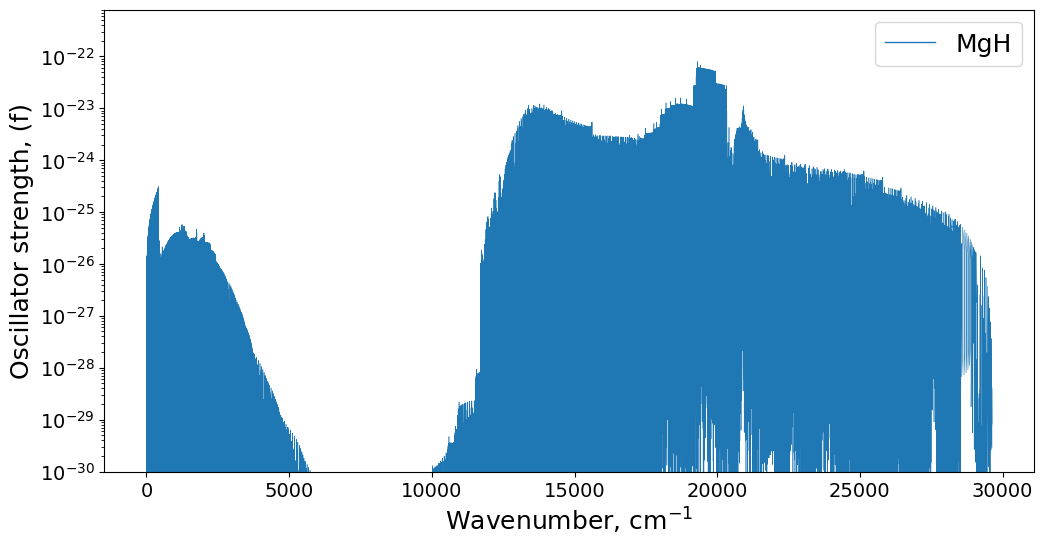

Oscillator strengths plot has been saved: /home/jingxin/data/pyexocross/oscillator_strength/plots/MgH/ExoMol/MgH__24Mg-1H__ExoMol__f__os.png 

Oscillator strengths have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Convert data format from ExoMol to HITRAN.
Running on  4 cores.
Reading transitions and converting data format from ExoMol to HITRAN ...
Number of all transitions files 		: 1
Number of all decompressed transitions files 	: 0
Number of new decompressed transitions files 	: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running time on CPU       : 4.637129475000002 s
Running time on system    : 4.644409656524658 s
Finished reading all transitions and converting data format from ExoMol to HITRAN!

Saving HITRAN format data into file ...
Running time on CPU       : 0.4805969120000029 s
Running time on system    : 0.4830176830291748 s
Converted par file has been saved!

Finished converting data format from ExoMol to HITRAN!
* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate stick spectra.
Running on  4 cores.
Uncertainty filter        : None   cm⁻¹
Threshold filter          : None   cm⁻¹/(molecule cm⁻²)
Wavenumber range selected : 0.0 cm⁻¹ - 30000.0 cm⁻¹
Reading transitions and calculating stick spectra ...
Number of all transitions files 		: 1
Number of selected transitions files 		: 1
Number of all decompressed transitions files 	: 0
Number of new decompressed transitions files 	: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running time on CPU       : 0.2509288050000009 s
Running time on system    : 0.23982548713684082 s
Finished reading transitions and calculating stick spectra!
Saving stick spectra into file ...
Running time on CPU       : 0.31769242499999706 s
Running time on system    : 0.3192777633666992 s
Stick spectra file has been saved: /home/jingxin/data/pyexocross/stick_spectra/files/MgH/ExoMol/MgH__24Mg-1H__XAB__T2000__0.0-30000.0__uncNone__thresNone__Ab.stick 

Plotting stick spectra ...


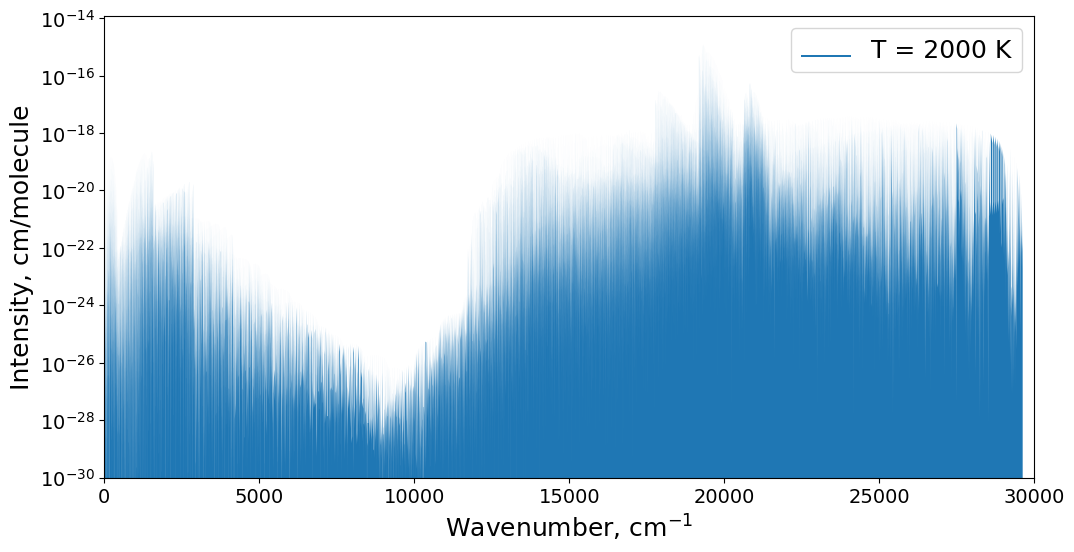

Running time on CPU       : 4.304022719999999 s
Running time on system    : 3.785126209259033 s
Stick spectra plot has been saved: /home/jingxin/data/pyexocross/stick_spectra/plots/MgH/ExoMol/MgH__24Mg-1H__XAB__T2000__0.0-30000.0__uncNone__Ab__sp.png
Stick spectra have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate non-LTE stick spectra.
Running on  4 cores.
Uncertainty filter        : None   cm⁻¹
Threshold filter          : None   cm⁻¹/(molecule cm⁻²)
Wavenumber range selected : 0.0 cm⁻¹ - 30000.0 cm⁻¹
Reading transitions and calculating stick spectra ...
Number of all transitions files 		: 1
Number of selected transitions files 		: 1
Number of all decompressed transitions files 	: 0
Number of new decompressed transitions files 	: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running time on CPU       : 0.3026586899999941 s
Running time on system    : 0.29242777824401855 s
Finished reading transitions and calculating non-LTE stick spectra!
Saving non-LTE stick spectra into file ...
Running time on CPU       : 0.31695378999999946 s
Running time on system    : 0.3188180923461914 s
Non-LTE stick spectra file has been saved: /home/jingxin/data/pyexocross/Non-LTE/files/MgH/ExoMol/MgH__24Mg-1H__XAB__Tvib2000__Trot296__0.0-30000.0__uncNone__thresNone__Ab.nlte 

Plotting Non-LTE stick spectra ...


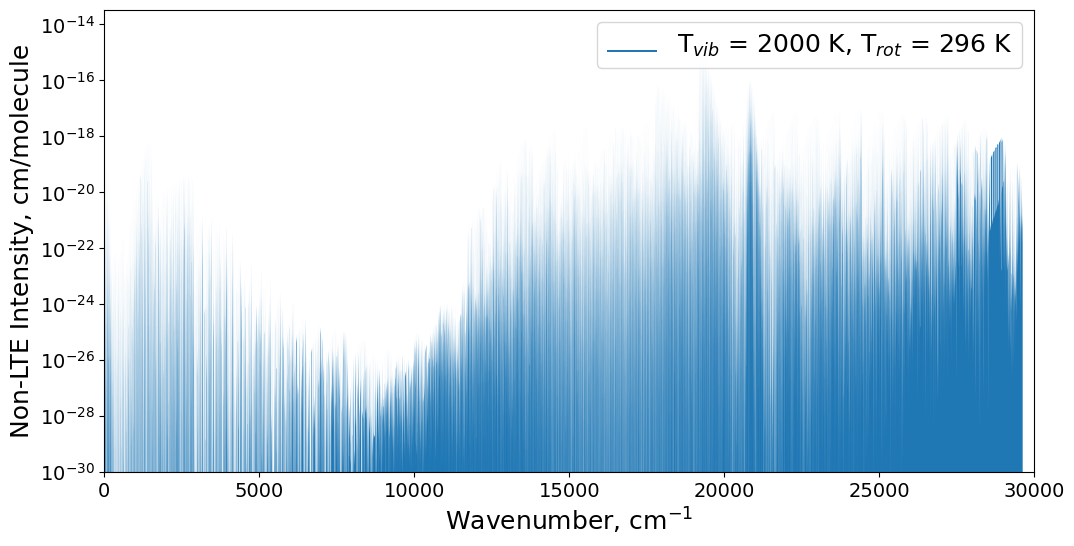

Running time on CPU       : 5.524323041999999 s
Running time on system    : 5.018362760543823 s
Non-LTE stick spectra plot has been saved: /home/jingxin/data/pyexocross/Non-LTE/plots/MgH/ExoMol/MgH__24Mg-1H__XAB__Tvib2000__Trot296__0.0-30000.0__uncNone__Ab__nlte.png
Non-LTE stick spectra have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *

Calculate cross sections.
Running on  4 cores.
Reading broadening file ...
Broadeners 	: Default
Ratios 		: 1.0 

Reading transitions and calculating cross sections ...
Number of all transitions files 		: 1
Number of selected transitions files 		: 1
Number of all decompressed transitions files 	: 0
Number of new decompressed transitions files 	: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Processeing transitions file: 24Mg-1H__XAB.trans.bz2


Processing 24Mg-1H__XAB.trans.bz2: 0it [00:00, ?it/s]

Running time on CPU       : 61.515122756000004 s
Running time on system    : 61.75600528717041 s
Finished reading transitions and calculating cross sections!

SciPy Voigt profile
Temperature selected      : 2000   K
Pressure selected         : 1.0    bar
Number of points is       : 300001
Bin size is               : 0.1    cm⁻¹
Cutoff is                 : 25.0   cm⁻¹
Uncertainty filter        : None   cm⁻¹
Threshold filter          : None   cm⁻¹/(molecule cm⁻²)
Wavenumber range selected : 0.0 cm⁻¹ - 30000.0 cm⁻¹
Cross sections file has been saved: /home/jingxin/data/pyexocross/xsecs/files/MgH/ExoMol/MgH__T2000__wn0.0-30000.0__ExoMol__Ab__SciPyVoigt.xsec 



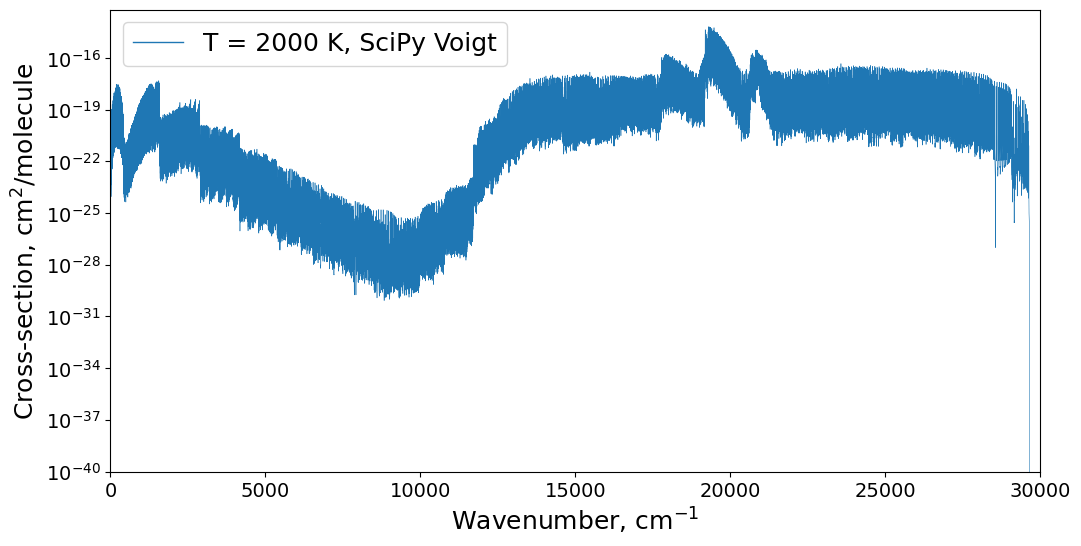

Cross sections plot has been saved: /home/jingxin/data/pyexocross/xsecs/plots/MgH/ExoMol/MgH__T2000__wn0.0-30000.0__ExoMol__Ab__SciPyVoigt.png 

Cross sections have been saved!

* * * * * - - - - - * * * * * - - - - - * * * * * - - - - - * * * * *


The program total running time:
Running time on CPU       : 102.57825706099999 s
Running time on system    : 92.5683069229126 s

Finished!


In [ ]:
get_results(read_path)